# Brain Tumor Detection with SyMPC - [v2]
### Oleksandr Lytvyn
dataset: https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from PIL import Image
import syft as sy
import time
device = torch.device('cpu')

torch.manual_seed(1)

In [2]:
from glob import glob
class BrainMRIDataset(Dataset):

    def __init__(self,data_dir,reshape=True,height=128,width=128, transform=None):
        self.dataDirectory = data_dir
        self.no_class = glob(data_dir+'/no/*')
        self.yes_class = glob(data_dir+'/yes/*')
        self.height = height
        self.width = width
        self.reshape=reshape
        self.transform = transform

        labels = [0 for i in range(len(self.no_class))]
        labels += [1 for i in range(len(self.yes_class))]

        image_links = self.no_class + self.yes_class
        self.dataframe = pd.DataFrame({
            'image':image_links,
            'labels': labels
        })

        self.dataframe = shuffle(self.dataframe)
        self.dataframe.reset_index(inplace=True,drop=True)

    def __len__(self):
        return len(self.no_class)+len(self.yes_class)

    def __getitem__(self,idx):

        image = self.dataframe['image'][idx]
        label = self.dataframe['labels'][idx]

        image = Image.open(image).convert("L")

        if self.reshape:
            image = image.resize((self.height,self.width))

        array = np.asarray(image)
        if self.transform:
            array = self.transform(array)
        
        array = array.reshape(1, self.height,self.width)
        image = torch.tensor(array)
        label = torch.tensor(label)

        return [image,label]

    def __repr__(self):
        return str(self.dataframe.head())


In [3]:
color_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.4),
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(brightness=0.6),
        transforms.ColorJitter(brightness=0.7)
    ]),
    transforms.ToTensor()
])

rotation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomRotation(degrees=30),
        transforms.RandomRotation(degrees=25),
        transforms.RandomRotation(degrees=20),
        transforms.RandomRotation(degrees=15)
    ]),
    transforms.ToTensor()
])

flip_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1)
        ])
    ]),
    transforms.ToTensor()
])

grayscale_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomChoice([
        transforms.Grayscale(),
        transforms.RandomPerspective(distortion_scale=.1, p=1)
    ]),
    transforms.ToTensor()
])

In [4]:
#upload data
path_to_project_root = '../../../'
data_dir = path_to_project_root + 'data/brain_tumor_imgs'
dataset = BrainMRIDataset(data_dir, height=64, width=64, transform=None) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=rotation_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=flip_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=grayscale_transformations) + \
          BrainMRIDataset(data_dir, height=64, width=64, transform=color_transformations)
print(dataset)

In [9]:
datasetsize = len(dataset)
train_size = int(datasetsize * 0.8)
whole_test_size = datasetsize - train_size
single_part_size = int(whole_test_size/3) #whole test data is divided into 3 parts - for test, do1 and do2

# if datasetsize != (train_size + single_part_size*3):
#     train_size += 1

print(f"Whole dataset size: {datasetsize}\n"
      f"Train dataset size: {train_size}\n"
      f"Whole train size: {whole_test_size}\n"
      f"Test, DO1 and DO2 sizes: {single_part_size}")

Whole dataset size: 1265
Train dataset size: 1012
Whole train size: 253
Test, DO1 and DO2 sizes: 84


1012, 253


<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


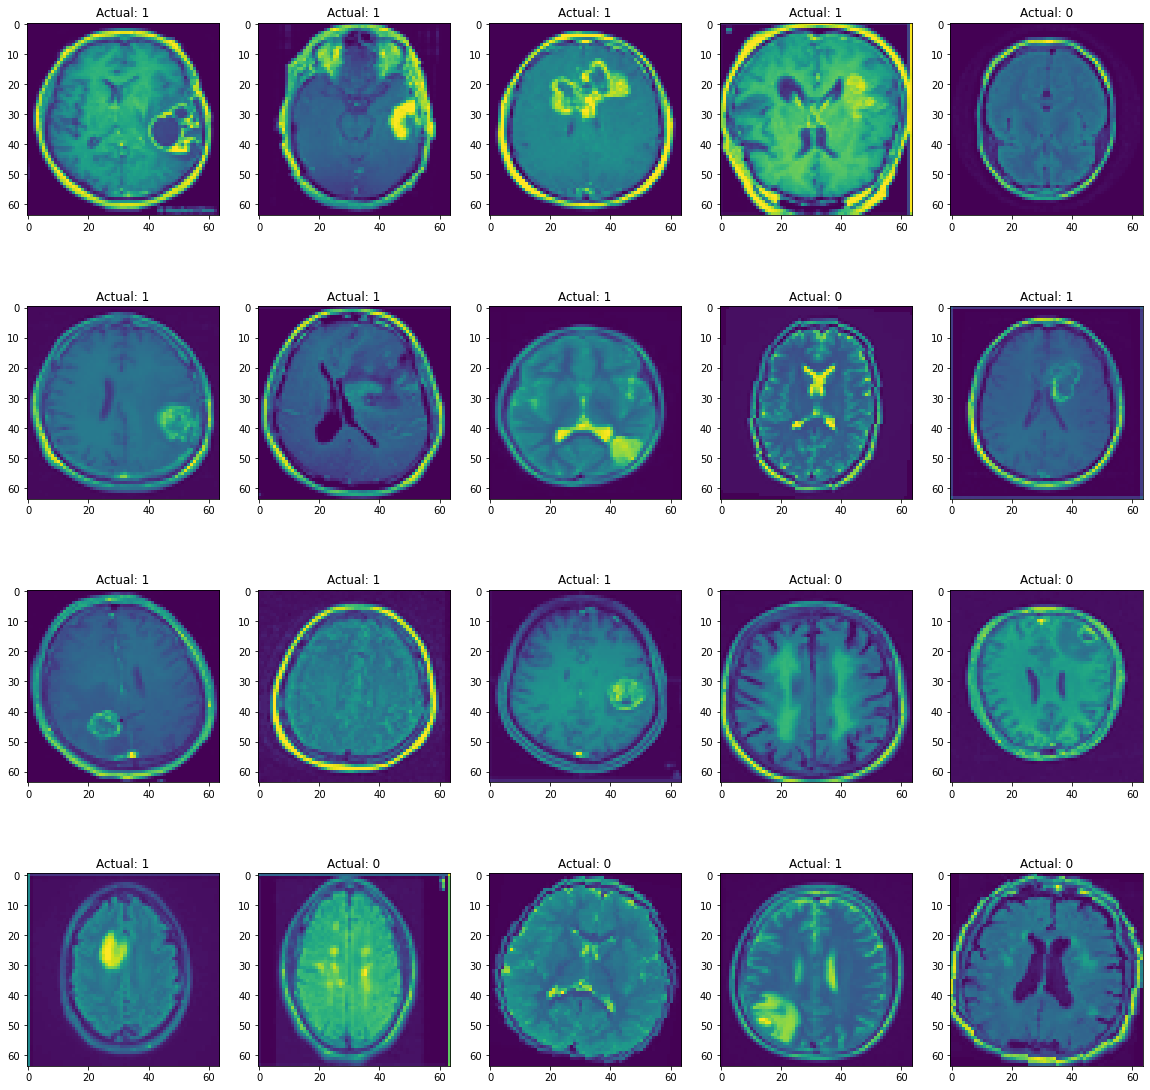

In [10]:
# train_data, test_data, do1_data, do2_data = torch.utils.data.random_split(dataset, [train_size, single_part_size, single_part_size, single_part_size])

train_data, test_data = torch.utils.data.random_split(dataset, [train_size, whole_test_size])
print(f"{len(train_data)}, {len(test_data)}")


fig = plt.figure(figsize=(20,20))
for i in range(20):
    target = train_data[i][1]
    plt.subplot(4,5, i+1)
    plt.imshow(train_data[i][0][0])
    plt.title(f'Actual: {target}')
plt.show()


#### MODEL with SyMPC wraper

In [11]:
class BrainTumorModel(sy.Module):
    def __init__(self, torch_ref):
        super(BrainTumorModel, self).__init__(torch_ref=torch_ref)
        self.conv1 = self.torch_ref.nn.Conv2d(1, 128, kernel_size=3)
        self.conv2 = self.torch_ref.nn.Conv2d(128,32,kernel_size=2)
        self.linear1 = self.torch_ref.nn.Linear(30,64)
        self.linear2 = self.torch_ref.nn.Linear(64,32)
        self.flat = self.torch_ref.nn.Flatten(1)
        self.linear3 = self.torch_ref.nn.Linear(30720,2)

    def forward(self,x):
        x = self.conv1(x)
        # print(x.shape)
        x = self.torch_ref.nn.functional.max_pool2d(x,2)
        # print(x.shape)
        x = self.conv2(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear1(x)
        x = self.torch_ref.nn.functional.relu(x)
        # print(x.shape)
        x = self.linear2(x)
        # print(x.shape)
        x = self.flat(x)
        # print(x.shape)
        x = self.linear3(x)
        # print(x.shape)

        return x

In [7]:
model = BrainTumorModel(torch_ref=torch)
print(model)

In [18]:
#dict example
# {
#     "model": BrainTumorModel(torch_ref=torch),
#     "learning_rate": 0.0001
#     "epochs": 100
# }
models_and_params = []

for i in range(1, 11):
    models_and_params.append({
        "model": BrainTumorModel(torch_ref=torch),
        "learning_rate": 0.0001,
        "epochs": 100*(i*2)
    })

print(models_and_params)

[{'model': <__main__.BrainTumorModel object at 0x7fe3d86c8160>, 'learning_rate': 0.0001, 'epochs': 200}, {'model': <__main__.BrainTumorModel object at 0x7fe3d8554f40>, 'learning_rate': 0.0001, 'epochs': 400}, {'model': <__main__.BrainTumorModel object at 0x7fe3d856f130>, 'learning_rate': 0.0001, 'epochs': 600}, {'model': <__main__.BrainTumorModel object at 0x7fe3d856fa30>, 'learning_rate': 0.0001, 'epochs': 800}, {'model': <__main__.BrainTumorModel object at 0x7fe3d856ffa0>, 'learning_rate': 0.0001, 'epochs': 1000}, {'model': <__main__.BrainTumorModel object at 0x7fe3d861f100>, 'learning_rate': 0.0001, 'epochs': 1200}, {'model': <__main__.BrainTumorModel object at 0x7fe3dadce1c0>, 'learning_rate': 0.0001, 'epochs': 1400}, {'model': <__main__.BrainTumorModel object at 0x7fe3dadce5e0>, 'learning_rate': 0.0001, 'epochs': 1600}, {'model': <__main__.BrainTumorModel object at 0x7fe3dadce940>, 'learning_rate': 0.0001, 'epochs': 1800}, {'model': <__main__.BrainTumorModel object at 0x7fe3dadceb

In [23]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.0001)
# num_epochs = 800

def test(model, test_loader, loss_fn):
    test_loss = 0
    accuracy = 0
    number_of_imags = len(test_loader)
    for image, label in test_loader:
        pred = model.forward(image.float())
        test_loss += loss_fn(pred, label).item()
        pred = torch.argmax(pred, dim=1)

        equality = (label.data == pred)
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss/number_of_imags, accuracy/number_of_imags


def train(model, train_data, test_data, optimizer, num_epochs = 100, batch_size = 32,):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        total_loss = 0
        i=0
        for batch in train_loader:
            optimizer.zero_grad()
            image, label = batch
            images_batch = Variable(image)
            labels_batch = Variable(label)
            output = model(images_batch.float())
            loss = loss_fn(output, labels_batch)
            total_loss += loss
            loss.backward()
            optimizer.step()
            i+=1
            break
        if epoch%10 == 0:
            model.eval()
            test_loss, accuracy = test(model, test_loader, loss_fn)
            print(f'Epochs: {epoch} Loss: {total_loss/i: .4f}, Accuracy: {accuracy: .4f}')
#             print('-----------------------------------------------')
            model.train()
        loss_list.append(total_loss/batch_size)
    return loss_list

In [25]:
# loss_list_dumb = train(model, train_data, test_data, num_epochs=num_epochs)


for idx, model_and_params in enumerate(models_and_params):
    # get attributes
    model = model_and_params["model"] 
    epochs = model_and_params["epochs"]
    optimizer = optim.Adam(model.parameters(), lr=model_and_params["learning_rate"])
    print(f"---------------------------------------")
    print(f"Started model {idx} for {epochs} epochs")
    start_time = time.time()
    # train model
    loss_list_dumb = train(model, train_data, test_data,optimizer, num_epochs=epochs)
    model_and_params["loss_list"] = [loss_item.detach() for loss_item in loss_list_dumb]
    
    
    print(f"Finished model {idx} for {epochs} epochs, for {time.time() - start_time}")
    print(f"---------------------------------------")
    
    

---------------------------------------
Started model 0 for 200 epochs


<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Epochs: 0 Loss:  0.6818, Accuracy:  0.5784
Epochs: 10 Loss:  0.5750, Accuracy:  0.6257
Epochs: 20 Loss:  0.7723, Accuracy:  0.6565
Epochs: 30 Loss:  0.5244, Accuracy:  0.6522
Epochs: 40 Loss:  0.5490, Accuracy:  0.6483
Epochs: 50 Loss:  0.7854, Accuracy:  0.6522
Epochs: 60 Loss:  0.6854, Accuracy:  0.6522
Epochs: 70 Loss:  0.5423, Accuracy:  0.6561
Epochs: 80 Loss:  0.4482, Accuracy:  0.6405
Epochs: 90 Loss:  0.4347, Accuracy:  0.6561
Epochs: 100 Loss:  0.4964, Accuracy:  0.6522
Epochs: 110 Loss:  0.4968, Accuracy:  0.6331
Epochs: 120 Loss:  0.6382, Accuracy:  0.7038
Epochs: 130 Loss:  0.5439, Accuracy:  0.6960
Epochs: 140 Loss:  0.5854, Accuracy:  0.6522
Epochs: 150 Loss:  0.4834, Accuracy:  0.6678
Epochs: 160 Loss:  0.4691, Accuracy:  0.7077
Epochs: 170 Loss:  0.4840, Accuracy:  0.7268
Epochs: 180 Loss:  0.3620, Accuracy:  0.7182
Epochs: 190 Loss:  0.4131, Accuracy:  0.7507
Finished model 0 for 200 epochs, for 78.85672545433044
---------------------------------------
----------------

Epochs: 520 Loss:  0.4116, Accuracy:  0.7694
Epochs: 530 Loss:  0.4435, Accuracy:  0.7581
Epochs: 540 Loss:  0.5453, Accuracy:  0.7464
Epochs: 550 Loss:  0.2685, Accuracy:  0.7741
Epochs: 560 Loss:  0.2957, Accuracy:  0.7659
Epochs: 570 Loss:  0.3884, Accuracy:  0.7589
Epochs: 580 Loss:  0.3119, Accuracy:  0.7542
Epochs: 590 Loss:  0.3657, Accuracy:  0.7503
Epochs: 600 Loss:  0.4940, Accuracy:  0.7546
Epochs: 610 Loss:  0.4514, Accuracy:  0.7663
Epochs: 620 Loss:  0.4377, Accuracy:  0.7620
Epochs: 630 Loss:  0.1835, Accuracy:  0.7381
Epochs: 640 Loss:  0.3404, Accuracy:  0.7655
Epochs: 650 Loss:  0.5230, Accuracy:  0.7776
Epochs: 660 Loss:  0.4831, Accuracy:  0.7858
Epochs: 670 Loss:  0.4328, Accuracy:  0.7655
Epochs: 680 Loss:  0.2394, Accuracy:  0.7663
Epochs: 690 Loss:  0.3182, Accuracy:  0.7702
Epochs: 700 Loss:  0.3207, Accuracy:  0.7936
Epochs: 710 Loss:  0.4391, Accuracy:  0.7741
Epochs: 720 Loss:  0.1829, Accuracy:  0.7780
Epochs: 730 Loss:  0.3147, Accuracy:  0.7862
Epochs: 74

Epochs: 480 Loss:  0.5849, Accuracy:  0.7663
Epochs: 490 Loss:  0.4486, Accuracy:  0.7702
Epochs: 500 Loss:  0.3543, Accuracy:  0.7659
Epochs: 510 Loss:  0.3343, Accuracy:  0.7706
Epochs: 520 Loss:  0.3718, Accuracy:  0.7706
Epochs: 530 Loss:  0.3376, Accuracy:  0.7745
Epochs: 540 Loss:  0.4284, Accuracy:  0.7667
Epochs: 550 Loss:  0.3977, Accuracy:  0.7858
Epochs: 560 Loss:  0.4279, Accuracy:  0.7702
Epochs: 570 Loss:  0.2732, Accuracy:  0.7745
Epochs: 580 Loss:  0.3305, Accuracy:  0.7702
Epochs: 590 Loss:  0.4046, Accuracy:  0.7550
Epochs: 600 Loss:  0.4062, Accuracy:  0.7663
Epochs: 610 Loss:  0.2232, Accuracy:  0.7780
Epochs: 620 Loss:  0.2541, Accuracy:  0.7901
Epochs: 630 Loss:  0.4715, Accuracy:  0.7589
Epochs: 640 Loss:  0.4434, Accuracy:  0.7667
Epochs: 650 Loss:  0.4057, Accuracy:  0.7819
Epochs: 660 Loss:  0.3113, Accuracy:  0.7628
Epochs: 670 Loss:  0.2808, Accuracy:  0.7780
Epochs: 680 Loss:  0.4165, Accuracy:  0.7581
Epochs: 690 Loss:  0.2319, Accuracy:  0.7702
Epochs: 70

Epochs: 1060 Loss:  0.3010, Accuracy:  0.8210
Epochs: 1070 Loss:  0.2668, Accuracy:  0.8171
Epochs: 1080 Loss:  0.4221, Accuracy:  0.8132
Epochs: 1090 Loss:  0.1476, Accuracy:  0.8331
Epochs: 1100 Loss:  0.8758, Accuracy:  0.7940
Epochs: 1110 Loss:  0.3986, Accuracy:  0.8011
Epochs: 1120 Loss:  0.3121, Accuracy:  0.8050
Epochs: 1130 Loss:  0.2813, Accuracy:  0.8253
Epochs: 1140 Loss:  0.2161, Accuracy:  0.8093
Epochs: 1150 Loss:  0.2707, Accuracy:  0.8136
Epochs: 1160 Loss:  0.4878, Accuracy:  0.8093
Epochs: 1170 Loss:  0.2206, Accuracy:  0.8253
Epochs: 1180 Loss:  0.2507, Accuracy:  0.8136
Epochs: 1190 Loss:  0.2736, Accuracy:  0.8261
Epochs: 1200 Loss:  0.3021, Accuracy:  0.8136
Epochs: 1210 Loss:  0.2097, Accuracy:  0.8335
Epochs: 1220 Loss:  0.3167, Accuracy:  0.8448
Epochs: 1230 Loss:  0.1627, Accuracy:  0.8370
Epochs: 1240 Loss:  0.2687, Accuracy:  0.8058
Epochs: 1250 Loss:  0.2301, Accuracy:  0.8132
Epochs: 1260 Loss:  0.2426, Accuracy:  0.8214
Epochs: 1270 Loss:  0.2611, Accura

Epochs: 1430 Loss:  0.1937, Accuracy:  0.8456
Epochs: 1440 Loss:  0.3934, Accuracy:  0.8570
Epochs: 1450 Loss:  0.1735, Accuracy:  0.8526
Epochs: 1460 Loss:  0.2497, Accuracy:  0.8452
Epochs: 1470 Loss:  0.2935, Accuracy:  0.8656
Epochs: 1480 Loss:  0.1432, Accuracy:  0.8530
Epochs: 1490 Loss:  0.2011, Accuracy:  0.8413
Epochs: 1500 Loss:  0.2781, Accuracy:  0.8409
Epochs: 1510 Loss:  0.2217, Accuracy:  0.8539
Epochs: 1520 Loss:  0.2352, Accuracy:  0.8495
Epochs: 1530 Loss:  0.2846, Accuracy:  0.8695
Epochs: 1540 Loss:  0.1541, Accuracy:  0.8765
Epochs: 1550 Loss:  0.2390, Accuracy:  0.8578
Epochs: 1560 Loss:  0.2364, Accuracy:  0.8730
Epochs: 1570 Loss:  0.2574, Accuracy:  0.8530
Epochs: 1580 Loss:  0.1350, Accuracy:  0.8652
Epochs: 1590 Loss:  0.1829, Accuracy:  0.8730
Finished model 7 for 1600 epochs, for 630.9136016368866
---------------------------------------
---------------------------------------
Started model 8 for 1800 epochs
Epochs: 0 Loss:  0.7883, Accuracy:  0.5319
Epochs:

Epochs: 1600 Loss:  0.2049, Accuracy:  0.8804
Epochs: 1610 Loss:  0.1409, Accuracy:  0.8734
Epochs: 1620 Loss:  0.3824, Accuracy:  0.8609
Epochs: 1630 Loss:  0.1637, Accuracy:  0.8656
Epochs: 1640 Loss:  0.1390, Accuracy:  0.8921
Epochs: 1650 Loss:  0.2544, Accuracy:  0.8921
Epochs: 1660 Loss:  0.3147, Accuracy:  0.8968
Epochs: 1670 Loss:  0.1696, Accuracy:  0.8925
Epochs: 1680 Loss:  0.1755, Accuracy:  0.8929
Epochs: 1690 Loss:  0.1413, Accuracy:  0.8855
Epochs: 1700 Loss:  0.1618, Accuracy:  0.8804
Epochs: 1710 Loss:  0.1937, Accuracy:  0.8964
Epochs: 1720 Loss:  0.2041, Accuracy:  0.9085
Epochs: 1730 Loss:  0.1541, Accuracy:  0.8882
Epochs: 1740 Loss:  0.1964, Accuracy:  0.8730
Epochs: 1750 Loss:  0.1196, Accuracy:  0.8839
Epochs: 1760 Loss:  0.1885, Accuracy:  0.8839
Epochs: 1770 Loss:  0.1827, Accuracy:  0.8882
Epochs: 1780 Loss:  0.3391, Accuracy:  0.8656
Epochs: 1790 Loss:  0.2709, Accuracy:  0.8683
Finished model 8 for 1800 epochs, for 716.5723104476929
------------------------

Epochs: 1570 Loss:  0.2613, Accuracy:  0.8483
Epochs: 1580 Loss:  0.2352, Accuracy:  0.8522
Epochs: 1590 Loss:  0.2320, Accuracy:  0.8366
Epochs: 1600 Loss:  0.1844, Accuracy:  0.8331
Epochs: 1610 Loss:  0.2298, Accuracy:  0.8726
Epochs: 1620 Loss:  0.0986, Accuracy:  0.8409
Epochs: 1630 Loss:  0.3972, Accuracy:  0.8483
Epochs: 1640 Loss:  0.2455, Accuracy:  0.8526
Epochs: 1650 Loss:  0.3037, Accuracy:  0.8444
Epochs: 1660 Loss:  0.2061, Accuracy:  0.8605
Epochs: 1670 Loss:  0.1918, Accuracy:  0.8452
Epochs: 1680 Loss:  0.2518, Accuracy:  0.8483
Epochs: 1690 Loss:  0.2228, Accuracy:  0.8448
Epochs: 1700 Loss:  0.2174, Accuracy:  0.8722
Epochs: 1710 Loss:  0.1785, Accuracy:  0.8483
Epochs: 1720 Loss:  0.2505, Accuracy:  0.8687
Epochs: 1730 Loss:  0.3566, Accuracy:  0.8409
Epochs: 1740 Loss:  0.3533, Accuracy:  0.8691
Epochs: 1750 Loss:  0.2964, Accuracy:  0.8609
Epochs: 1760 Loss:  0.1170, Accuracy:  0.8726
Epochs: 1770 Loss:  0.4295, Accuracy:  0.8648
Epochs: 1780 Loss:  0.2591, Accura

### Models evaluation + Loss Plot

In [29]:
len(models_and_params)

10

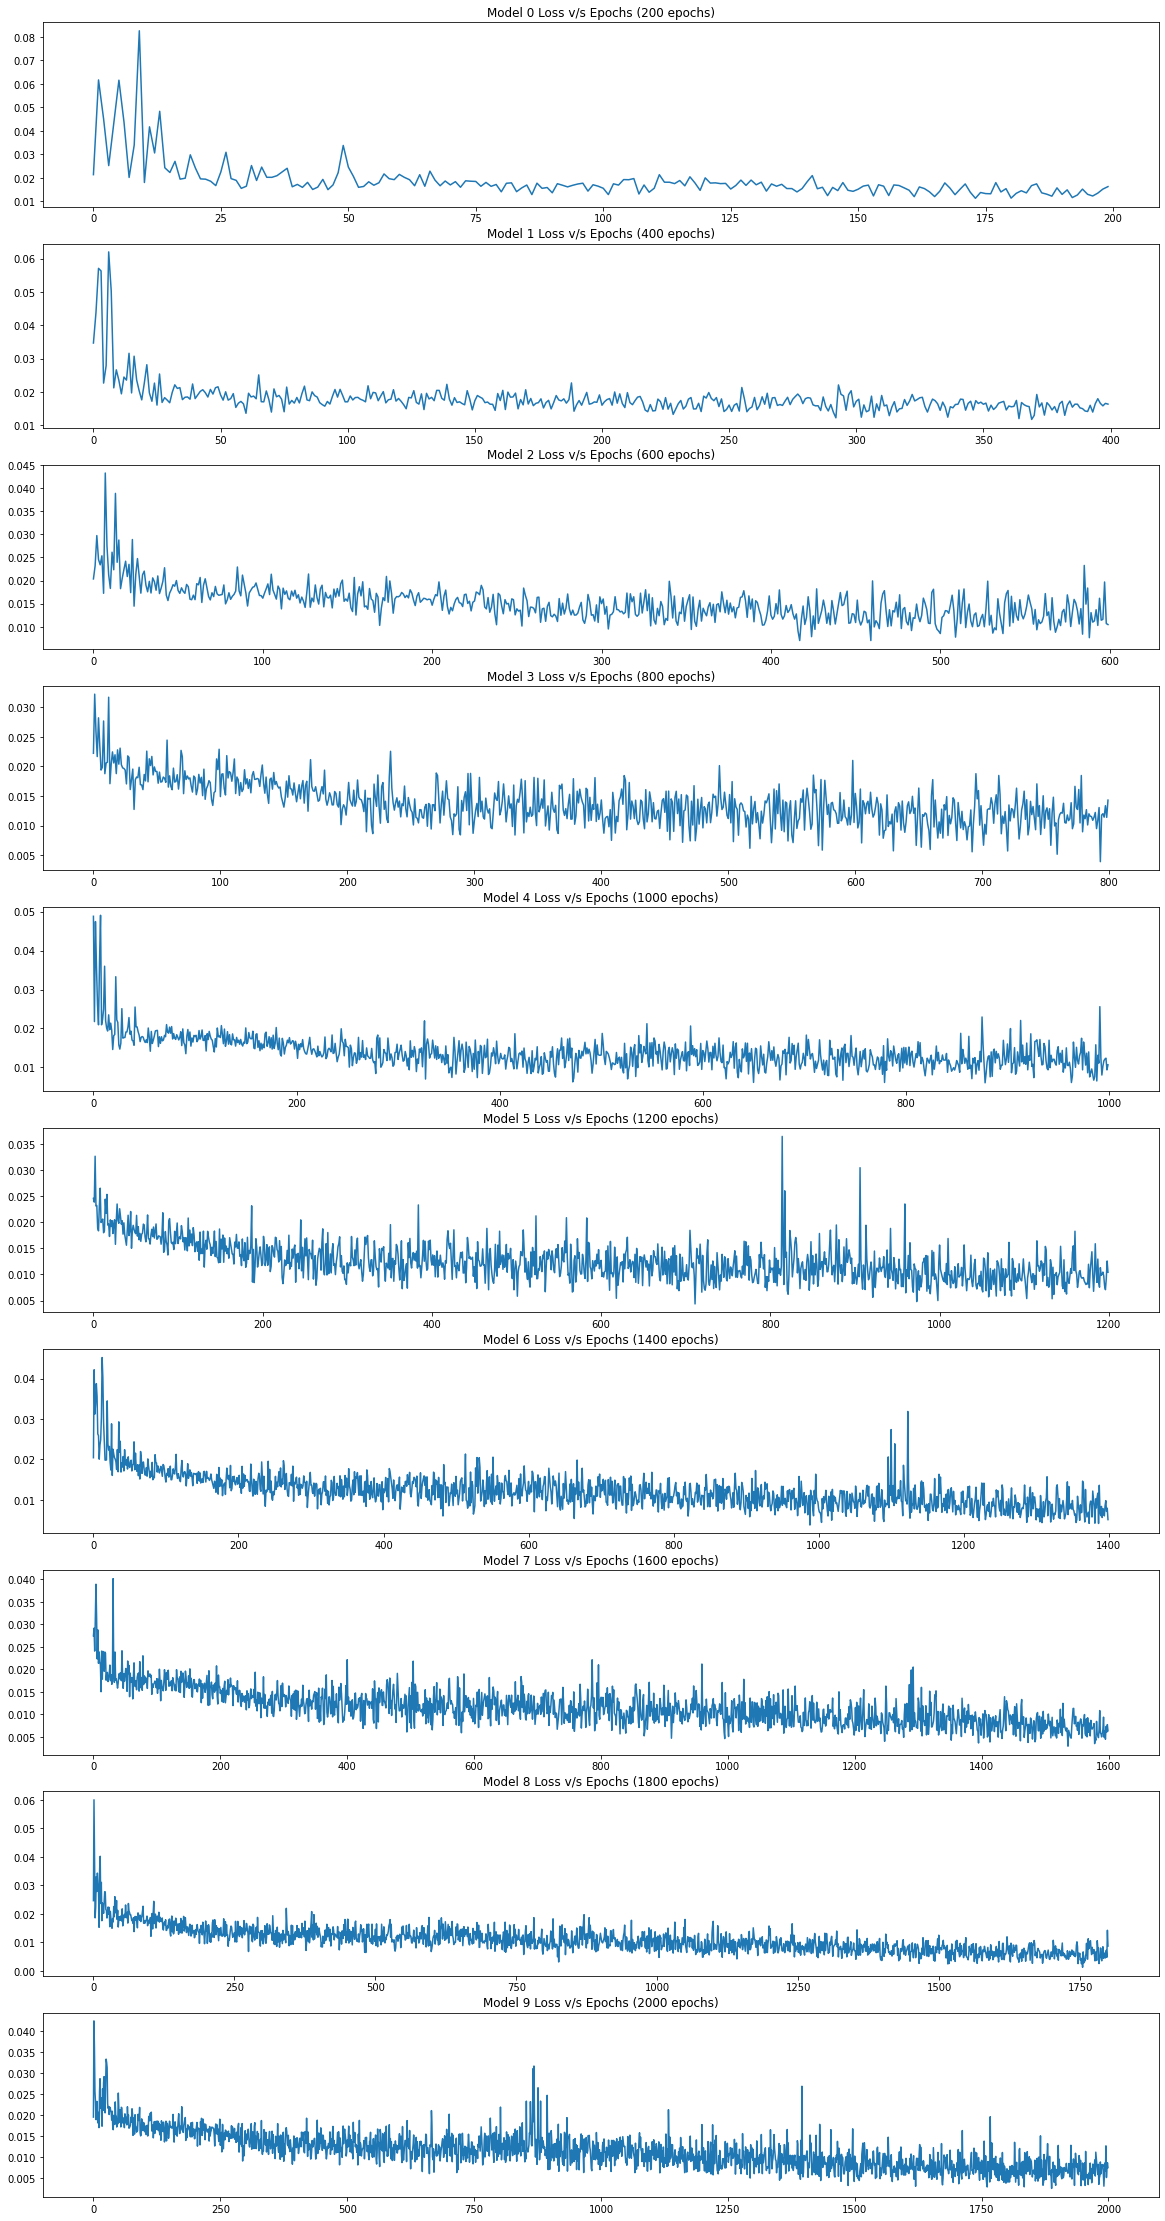

In [35]:
# loss_list = train(model, train_data, test_data, num_epochs=num_epochs)
# loss_list = [loss_item.detach() for loss_item in loss_list_dumb]

# fig = plt.figure(figsize=(20,20))
fig, axs = plt.subplots(10, figsize=(20,40))

for x in range(0,10):
    # 1st column
    first_model_and_params = models_and_params[x]
    axs[x].plot(list(range(first_model_and_params["epochs"])), first_model_and_params["loss_list"])
    axs[x].set_title(f"Model {x} Loss v/s Epochs ({first_model_and_params['epochs']} epochs)")
    

plt.figure
plt.show()

# plot = True
# if plot:
#     fig = plt.figure(figsize=(10,10))
#     plt.plot(list(range(num_epochs)),loss_list)
#     plt.title("Loss v/s Epochs")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.show()

In [40]:
#Evaluate trained models

for idx, model_and_params in enumerate(models_and_params):
    print(f"Evaluating model {idx}")
    model = model_and_params["model"]
    model.eval()
    
    test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
    test_loss, accuracy, = test(model, test_loader, loss_fn)
    print(f'Test Accuracy: {accuracy:.4f} |'
          f'Test Loss: {test_loss:.4f}\n')


Evaluating model 0


<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


Test Accuracy: 0.7312 |Test Loss: 0.6076

Evaluating model 1
Test Accuracy: 0.7470 |Test Loss: 0.6318

Evaluating model 2
Test Accuracy: 0.7589 |Test Loss: 0.6316

Evaluating model 3
Test Accuracy: 0.7826 |Test Loss: 0.5840

Evaluating model 4
Test Accuracy: 0.7866 |Test Loss: 0.5290

Evaluating model 5
Test Accuracy: 0.8142 |Test Loss: 0.5010

Evaluating model 6
Test Accuracy: 0.8538 |Test Loss: 0.4070

Evaluating model 7
Test Accuracy: 0.8617 |Test Loss: 0.6990

Evaluating model 8
Test Accuracy: 0.8893 |Test Loss: 0.4359

Evaluating model 9
Test Accuracy: 0.8972 |Test Loss: 0.7280



In [42]:
# chosing the 8th model as the main one
model = models_and_params[8]["model"]

<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


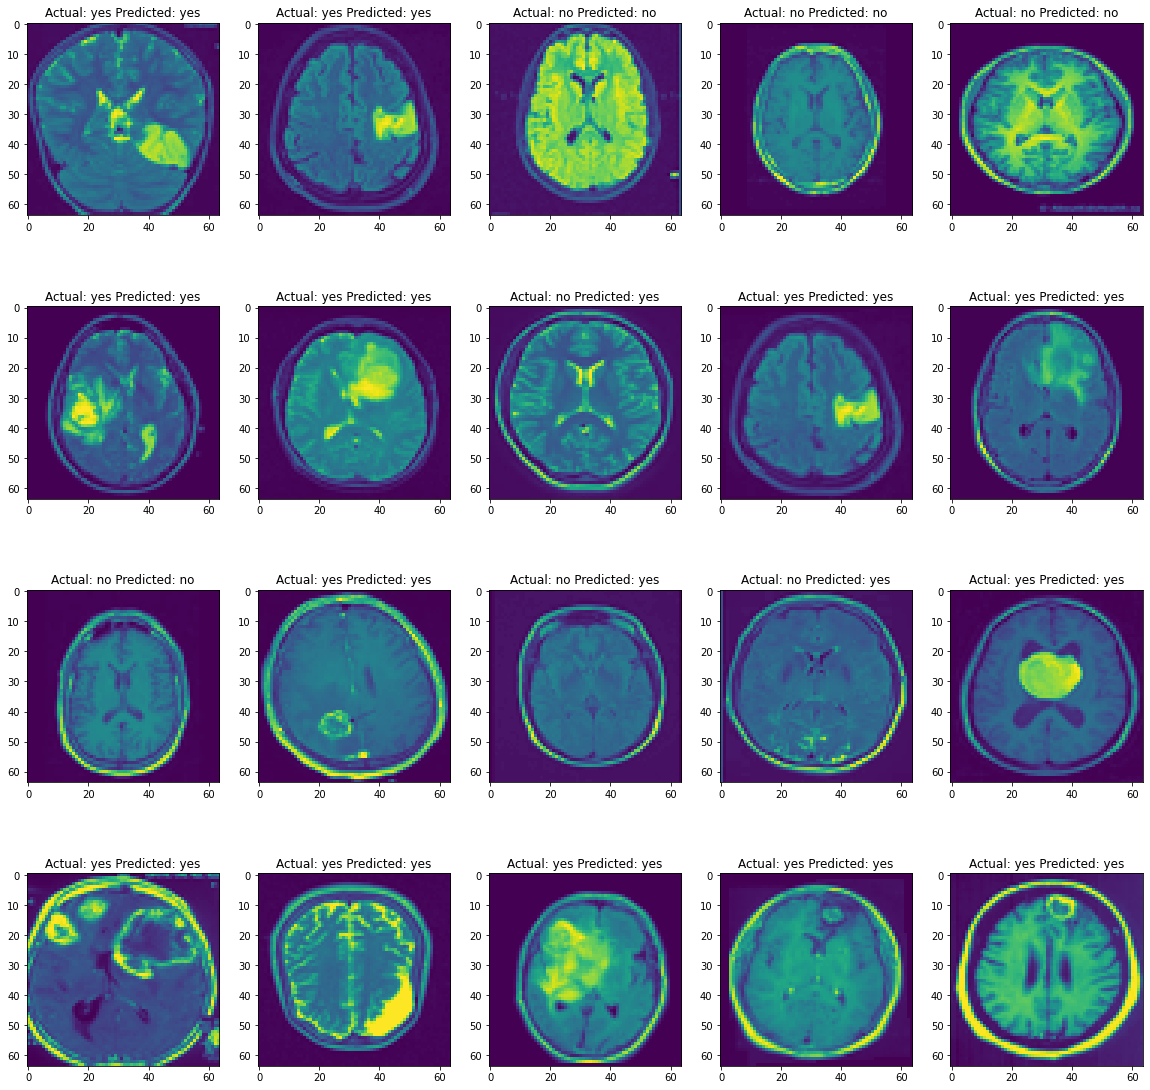

actual accuracy:  0.85


In [43]:
plot_loader = DataLoader(test_data, batch_size=1)

mapping = {0:'no',1:'yes'}
fig = plt.figure(figsize=(20,20))
i = 0
correct = 0
raw_predictions = []
for img, lbl in plot_loader:
    if i == 20: break
    pred = model(img.float())
#     print(pred)
    pred = torch.argmax(pred,dim=1)
    raw_predictions.append(pred)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0].cpu())
    if lbl == pred: correct += 1
    plt.title(f'Actual: {mapping[lbl.cpu().detach().item()]} Predicted: {mapping[pred.cpu().detach().item()]}')
    i+=1
plt.show()
print(f"actual accuracy: {correct/i: .2f}")

### SyMPC part


In [44]:
import sympc
from sympc.session import Session
from sympc.session import SessionManager
from sympc.tensor import MPCTensor
from sympc.protocol import FSS
from sympc.protocol import Falcon

In [45]:
def get_clients(n_parties):
  #Generate required number of syft clients and return them.

  parties=[]
  for index in range(n_parties):
      parties.append(sy.VirtualMachine(name = "worker"+str(index)).get_root_client())

  return parties

def split_send(data,session):
    """Splits data into number of chunks equal to number of parties and distributes it to respective
       parties.
    """
    image_pointers = []

#     split_size = int(len(data)/len(session.parties))+1
    split_size = int(len(data)/len(session.parties))


    for index in range(0,len(session.parties)):
#         ptr=data[index*split_size:index*split_size+split_size].share(session=session)
        ptr=data[index*split_size:index*split_size+split_size]
        image_pointers.append(MPCTensor(secret=ptr, session=session))

    return image_pointers

In [46]:
#creating parties and session
parties = get_clients(2)
session = Session(parties=parties)
SessionManager.setup_mpc(session)



In [47]:
# default split data
ptrs = []
labels = []
for i, (img, lbl) in enumerate(plot_loader):
#     if i == 20: break
    img_f = img.type(torch.float32)
    ptrs.append(MPCTensor(secret=img_f,session=session, requires_grad=True))
    labels.append(lbl)   
len(ptrs)



<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)


253

In [48]:
mpc_model = model.share(session)
mpc_model

In [49]:
#Perform inference and measure time taken
start_time = time.time()

results = []

for ptr in ptrs:
    encrypted_results = mpc_model(ptr)
    print(f"encrypted results: {encrypted_results}")
    plaintext_results = encrypted_results.reconstruct()
    print(f"plain text results: {plaintext_results}")
    results.append(plaintext_results)

end_time = time.time()
results

[2022-03-19T16:41:12.404047+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7cc88e72e7eb40e2ba79f14fe7b34bb3>.
[2022-03-19T16:41:12.411142+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75a149eb111e42d495917a8c4209e5c2>.
[2022-03-19T16:42:23.635290+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb7ccc68ee9444119fc57f4953f22df7>.
[2022-03-19T16:42:23.640167+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40418e9cd1a44568ac5a7b3ab5afb24c>.
[2022-03-19T16:43:00.168438+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6ee4fc8ab1346dfaaa02fc11f5a7054>.
[2022-03-19T16:43:00.171239+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7bf4c169fe454c7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.0059,  1.0164]])


[2022-03-19T16:43:09.589390+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5cdf4caf90e4008a859afcd37d011a1>.
[2022-03-19T16:43:09.594266+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 085fcd7484154b6694f8d51ab2ab05be>.
[2022-03-19T16:43:09.611407+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f3dade7db53e4c339d257e9897eb3b19>.
[2022-03-19T16:43:09.616410+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2943630d53fe4accb2c928b158bb4c66>.
[2022-03-19T16:43:09.624410+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a98673c2ca384892b480f4f6fdaba95a>.
[2022-03-19T16:43:09.627491+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2786173f77594a5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.4297, -1.7271]])


[2022-03-19T16:45:07.452802+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a9e85a2eff440b6a34f48e15a1c5c0d>.
[2022-03-19T16:45:07.467519+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 541a4155fc284ba89c7105ca23242ec1>.
[2022-03-19T16:45:07.474605+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21bfa8475966409b94f4a81ba7144aa6>.
[2022-03-19T16:45:07.477671+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b991828e672f43d98954ddf392370432>.
[2022-03-19T16:45:07.487657+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 864414752e824494bf548af14b28832b>.
[2022-03-19T16:45:07.490870+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 185b3dfe7eb44ef

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.7806, -1.8001]])


[2022-03-19T16:47:08.626054+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dc398dea6ee4225845b13c51909fda0>.
[2022-03-19T16:47:08.632626+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 35a9068a37254a969169af6814443fe1>.
[2022-03-19T16:47:08.645654+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d01dd95caf154e678d333ee8eac3ab1c>.
[2022-03-19T16:47:08.651684+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4acfde2db4d34f9dbacf025126b9c8a5>.
[2022-03-19T16:47:08.669907+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e93f383cd7540869f7e08096ce83b6a>.
[2022-03-19T16:47:08.673240+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 597d71e17090428

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.4773, -3.6135]])


[2022-03-19T16:49:09.687067+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d909ff7c9f42432c85b27321b44aff9a>.
[2022-03-19T16:49:09.695964+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0bf8c5cd062d4e9485e0a04d8b933ef8>.
[2022-03-19T16:49:09.708963+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b870bf9f23a4456abc25487170b31b7>.
[2022-03-19T16:49:09.717052+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 085ae6f179cd42e5afe3d914c299fd6e>.
[2022-03-19T16:49:09.940336+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5ebf1c90006448e9b16db8ff3b73440>.
[2022-03-19T16:49:09.943197+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 320eacea79c9455

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3249, -0.5465]])


[2022-03-19T16:51:07.378917+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e7577cf0f00436ca44d1bcf36724449>.
[2022-03-19T16:51:07.386934+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62883640f69148648978dd8c389b8378>.
[2022-03-19T16:51:07.393692+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea5710c4f5e84aa7a69fa819135e17e6>.
[2022-03-19T16:51:07.396265+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c641c5403ea4033bec22e027580388e>.
[2022-03-19T16:51:07.405008+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f22831aaa8d54750bf69386b423ba64a>.
[2022-03-19T16:51:07.407617+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ec94f89b07e414

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.5363, -1.6653]])


[2022-03-19T16:53:08.325751+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 50d691ee89474eafbf1cb8e44d951e56>.
[2022-03-19T16:53:08.331930+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 822f26f72c574aff886f0399459bce9a>.
[2022-03-19T16:53:08.345755+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b4d76ccc1cc4a8088c3dc17e425f281>.
[2022-03-19T16:53:08.352860+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f6c9e97441d45d78f90a6a511ddfd16>.
[2022-03-19T16:53:08.370416+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ce0cc395a2743f2a2e92997614439ff>.
[2022-03-19T16:53:08.373075+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5aaf24d09bcd480

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-11.1068,  14.1469]])


[2022-03-19T16:55:08.130318+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c110131936074caab0e657325f0e0a88>.
[2022-03-19T16:55:08.141067+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 882f4c8947954ac4becd4f682da7166e>.
[2022-03-19T16:55:08.160899+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eea3249a21d744f58e456f509a68636b>.
[2022-03-19T16:55:08.172460+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77819f5bc2c44e5d9687328262d2560a>.
[2022-03-19T16:56:19.880316+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f44ec68d90c64c9f8bb53c535f1828c2>.
[2022-03-19T16:56:19.892332+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c10d79e94de41a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9728,  1.0874]])


[2022-03-19T16:57:06.459299+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54795b9e7a5a44d8b7087b3fbd206204>.
[2022-03-19T16:57:06.466762+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8328f6944a845a4af2ed696e252494a>.
[2022-03-19T16:57:06.477803+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8352b51abc12467e9d4b528c05eee8d6>.
[2022-03-19T16:57:06.482842+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b9b466e2e9964f8687331bcdf5b5f3fd>.
[2022-03-19T16:57:06.496374+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3fb0b98b83cc4f2dbfc7f1341e12d90a>.
[2022-03-19T16:57:06.499278+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ceea2c41e942456

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.0247,  1.9682]])


[2022-03-19T16:59:05.616498+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e56dad1553f4fabb5188d06f590fb00>.
[2022-03-19T16:59:05.624653+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 172bdbf3b8494b0ab00623da0e178722>.
[2022-03-19T16:59:05.638255+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48d5a2ab08b5421b9bbd1e3925e0f89d>.
[2022-03-19T16:59:05.644032+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40517270f96445aaa0c32310e9b3bb2d>.
[2022-03-19T17:00:18.319928+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f970830bd77d471c9c4dc8844a761a79>.
[2022-03-19T17:00:18.328084+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 887b96986e884b3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.1956, 4.3025]])


[2022-03-19T17:01:04.800095+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 542c946f41924af691d4ea7d23a86581>.
[2022-03-19T17:01:04.808218+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ca23c783dc74826874fa6884db1e04a>.
[2022-03-19T17:01:04.828377+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 033338bb6ac244b3a4784eaa4abb0d76>.
[2022-03-19T17:01:04.831639+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3049fdbd31c44790bf7940f37ac634b5>.
[2022-03-19T17:01:04.841724+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd892c63f3c84ebf92d4fed6c2ab9593>.
[2022-03-19T17:01:04.844709+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4b4ccf47a9a49e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.3885, -1.4420]])


[2022-03-19T17:03:05.789916+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82c545379fb14e99a998406adc6a0dd2>.
[2022-03-19T17:03:05.797568+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf7016d17b554a1fafd35e3082d35972>.
[2022-03-19T17:03:05.821249+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 584560a531374013bff98388f697967f>.
[2022-03-19T17:03:05.824147+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f0e992a0ab04f2eae8e7e510901f646>.
[2022-03-19T17:03:05.828351+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 757ae212b698480a8d5d65b55a0bc3ea>.
[2022-03-19T17:03:05.831028+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 86b3754c785c43b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3153,  2.4065]])


[2022-03-19T17:05:06.601950+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3333c77e131548b08a48d31e19354d73>.
[2022-03-19T17:05:06.610776+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 788e051a6f0040d4b1cf38931093d62b>.
[2022-03-19T17:06:18.385715+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d19db381a5924eb385c574f058f08905>.
[2022-03-19T17:06:18.391218+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7dc43153086b4c63b68ce6f2869f6814>.
[2022-03-19T17:06:54.426393+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c286c71524b346c38e2d7dc8c63c12e4>.
[2022-03-19T17:06:54.430044+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15c6db36148e4a6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3129,  0.2766]])


[2022-03-19T17:07:05.338133+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 50b88210df104801a9812c3bb6d4d021>.
[2022-03-19T17:07:05.347935+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54f18e34600847e0942947a6ec17f1b1>.
[2022-03-19T17:07:05.363597+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be95283348d749c193bbdd516f24217f>.
[2022-03-19T17:07:05.369658+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c68527d458b4aa5918a6ec68e5108ce>.
[2022-03-19T17:07:05.384076+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae394096f2c549a8acec2db302aed03f>.
[2022-03-19T17:07:05.387107+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60bef7f1d8d6450

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.1689,  1.1518]])


[2022-03-19T17:09:02.764265+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bed23c8a11494326bcac78360dfcefcb>.
[2022-03-19T17:09:02.769818+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a2d6cfa7ccfd427e8b38f37aa1fa439a>.
[2022-03-19T17:09:02.783262+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c7c48d5c7944e0fbfb6a42c23761f38>.
[2022-03-19T17:09:02.790844+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a232fe9c237243ec90837013821a0212>.
[2022-03-19T17:09:02.969246+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fca8f209a9ef43c2833a5538b2b8a2ea>.
[2022-03-19T17:09:02.972564+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18192bdd429a434

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.9087,  2.8920]])


[2022-03-19T17:11:00.224199+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8621a15e79d437cba9161f1134d1eae>.
[2022-03-19T17:11:00.229638+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 08f73f4332914d85bd19fafe6ae80b17>.
[2022-03-19T17:11:00.243186+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 41d7de1cd4e94ae297b15b36bb0c229d>.
[2022-03-19T17:11:00.246354+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b4117079fc24474b967bf100b0ff728>.
[2022-03-19T17:11:00.268447+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 384cc2ee0cb54ccfbcdf3f8914a66384>.
[2022-03-19T17:11:00.271278+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90056ab96b93414

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5513,  1.5884]])


[2022-03-19T17:13:02.008564+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe9451377b384f1d99fc3ad9f5d91cac>.
[2022-03-19T17:13:02.019651+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76a66bd549f942cbab08fd39cb503d45>.
[2022-03-19T17:13:02.036529+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 433ae92cf4a2402ca2077d281738c78b>.
[2022-03-19T17:13:02.044421+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b338e5be4bd4aeab77fb0646c4474de>.
[2022-03-19T17:13:02.062789+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b1aa594adc7493e861113d61f2fd724>.
[2022-03-19T17:13:02.066255+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e7bb20f0e99466

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.0744,  1.0871]])


[2022-03-19T17:14:59.205689+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc525e56a3054365b3269216ff3bb0c4>.
[2022-03-19T17:14:59.213699+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b89da9c459440ac85cc3ebc9c4c6042>.
[2022-03-19T17:14:59.406134+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1cbae2617db4d2a92bf4273608d0726>.
[2022-03-19T17:14:59.415054+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e38b734c6e134935bd17024e49e2d6c2>.
[2022-03-19T17:16:09.974268+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2accd3ba071d4031bb8373997720c70a>.
[2022-03-19T17:16:09.980498+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b8544abd3ee409

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.6768,  1.4743]])


[2022-03-19T17:16:57.591892+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5b209f9016941d085872f41dbb4b0aa>.
[2022-03-19T17:16:57.600207+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5294155e17444375a366e6dec1f07569>.
[2022-03-19T17:16:57.617414+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b7b3c60834c4da7a39478423f9de69d>.
[2022-03-19T17:16:57.625265+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98af76f6f48f4bd08702ba9aeb4eb74f>.
[2022-03-19T17:16:57.646255+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79386b5499b84a62b32d3185f5bd69cd>.
[2022-03-19T17:16:57.649866+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf57c949f2df4d0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3117,  2.2710]])


[2022-03-19T17:18:55.871728+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e0196dbf2386452cb905ffd8fcd2dda2>.
[2022-03-19T17:18:55.885236+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11b3c0b4ec084204a1414b1afaa60a5a>.
[2022-03-19T17:18:55.906396+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8dfacf887454f04ab796dad78a9a99f>.
[2022-03-19T17:18:55.913896+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c5db5ec756348f3abe40ea416a0c7f1>.
[2022-03-19T17:20:07.810401+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22a1c5711ffb4c1eb8c342e3b6767a44>.
[2022-03-19T17:20:07.819672+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 054bee50a4034fd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.5077,  2.5976]])


[2022-03-19T17:20:54.280085+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81875311fe4b46a9b3ba9a5445a29132>.
[2022-03-19T17:20:54.287849+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4b6256949f94e08976b2f21321402d3>.
[2022-03-19T17:20:54.302518+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 910354148ab94625b28c04ad373c4ea0>.
[2022-03-19T17:20:54.308040+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05266bfa7875404c9d0297da007c336e>.
[2022-03-19T17:20:54.319872+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49d9df5a93e4441db9b5f970913f1b6a>.
[2022-03-19T17:20:54.322541+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01c50b01fbda49c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9447,  1.0159]])


[2022-03-19T17:22:53.608899+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b581b44b8d7a4cda945b596a967e4ea9>.
[2022-03-19T17:22:53.620483+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81c6a2482d6440baad0603191e2ff095>.
[2022-03-19T17:22:53.646816+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21d04f5267ce4eb880d4a34bc2871d13>.
[2022-03-19T17:22:53.657071+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3d2d4dd4c0f48ef8dd1c09f7fa9d17a>.
[2022-03-19T17:22:53.661953+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7596e4b9a4a4fbe99e670dda437f8ca>.
[2022-03-19T17:22:53.664690+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd070e8b4cc543a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.7847,  1.7866]])


[2022-03-19T17:24:53.977826+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 72e65ccef3a542d18a17afcadadae56b>.
[2022-03-19T17:24:53.985680+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4317448f93b4e5f974aa83a4e1e21ab>.
[2022-03-19T17:26:06.433918+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ef689d9a4774e3ea7e5aa20f4373c8e>.
[2022-03-19T17:26:06.439857+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34bd67af41d546db99a52d7b8da14854>.
[2022-03-19T17:26:42.177537+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e444d2ce2def487caccb8f3fe9142e69>.
[2022-03-19T17:26:42.182218+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c4a418a05b3421

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.0081, -0.0582]])


[2022-03-19T17:26:52.146778+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c52a5d8c942b4471bfcb0bdb013a12ba>.
[2022-03-19T17:26:52.152114+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ac3a53d335c4e86890b99eeb0b5772a>.
[2022-03-19T17:26:52.164392+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74c65cc68bb449f3aee276d33c7adef3>.
[2022-03-19T17:26:52.169912+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80f4ba3944b949c7b8c12e145cb4bfa0>.
[2022-03-19T17:26:52.185861+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb794ae2bbf544519ef2ddaeea4bbf46>.
[2022-03-19T17:26:52.188644+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 249d44b318f741a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 20.8721, -19.0674]])


[2022-03-19T17:28:51.554464+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ec3da2689034c7d9bd84c1b71ff6021>.
[2022-03-19T17:28:51.561140+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb1c9b3e99ce49a09ad4e14fc42e0cde>.
[2022-03-19T17:28:51.588303+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 895a7778df7f4cdd8a3643a90e3c9754>.
[2022-03-19T17:28:51.596363+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 303b7e3f11b3449f8dbdb159be8f6f02>.
[2022-03-19T17:28:51.608090+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b9b43448dc504ed98f7a0411bdcc4a84>.
[2022-03-19T17:28:51.611697+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c77f447bb1714eb

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9823,  0.6766]])


[2022-03-19T17:30:48.590514+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc8b9848779d49d3b91e5e500c15b0a3>.
[2022-03-19T17:30:48.599739+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3679b1cc6102452cb4e38d0dfd43910c>.
[2022-03-19T17:30:48.611123+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3a92b14e4319498bbca7ee8b7f1b91ab>.
[2022-03-19T17:30:48.613837+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1086c3756a3743eb8d22e8f4c5db3dce>.
[2022-03-19T17:30:48.623222+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71700cc2b5594a6d8426bb6d77388667>.
[2022-03-19T17:30:48.625696+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3f47e1ca31143a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2281,  0.1343]])


[2022-03-19T17:32:49.685588+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 498a3a735b9947b99dd8a0e081e13910>.
[2022-03-19T17:32:49.690883+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 145ce4df233547f7b9fa49b9e3f6ce66>.
[2022-03-19T17:32:49.710018+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: acbef3d49b74401b949803d586c36953>.
[2022-03-19T17:32:49.715223+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a45c72c4b49f498bb330abf4e2dc0600>.
[2022-03-19T17:32:49.723552+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd2969505d254430bb7934823aa55a73>.
[2022-03-19T17:32:49.726211+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 72e3c8775a3d4cd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.7248,  1.7794]])


[2022-03-19T17:34:47.173213+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2a2a1813cef4de7bfe96fac9946eed8>.
[2022-03-19T17:34:47.178931+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 441d4b5157a943a5ad59d07f582d8a20>.
[2022-03-19T17:35:59.250337+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c58e66e30f7487499315ed8fd41840f>.
[2022-03-19T17:35:59.255238+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48588b49ffd340dfba7723d371691715>.
[2022-03-19T17:36:35.930461+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ded56ae097845feacccb7b94d0eede5>.
[2022-03-19T17:36:35.933632+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cdb771c83f674ab

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.7541, -1.7965]])


[2022-03-19T17:36:45.590823+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 219281315ffd4545abb79679521626da>.
[2022-03-19T17:36:45.596055+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b255a1a5996540e185834200227fe9b4>.
[2022-03-19T17:36:45.608285+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa31aea5037349ba8ddfbd1c8f0e9952>.
[2022-03-19T17:36:45.613963+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e91fe1c3b5e848d4a3f7bc8bf77d86d4>.
[2022-03-19T17:36:45.629866+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47f30df724054182a06f396bf66381c8>.
[2022-03-19T17:36:45.632602+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 08a4dd4743124e1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 10.0433, -10.0961]])


[2022-03-19T17:38:43.094291+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ec9db6bdc2647d4bdc40136211cf61c>.
[2022-03-19T17:38:43.101218+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6bae9b4b71c24995b479f76662b341b6>.
[2022-03-19T17:38:43.112440+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 199280973812434a85b0bfbb279ae278>.
[2022-03-19T17:38:43.120193+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 00ced5dac35943ec87d4e00d4014d141>.
[2022-03-19T17:38:43.395080+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1abdd88a8aa43b38699fbdef8022225>.
[2022-03-19T17:38:43.397998+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca22678ef309483

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5452,  0.4807]])


[2022-03-19T17:40:38.562818+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6ef369259834a28b25574e302125a92>.
[2022-03-19T17:40:38.567718+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 871b412301fc4bcd89cbe1fae438870b>.
[2022-03-19T17:40:38.573912+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7f51edfdc194d6e9e47daef4a4f5b7e>.
[2022-03-19T17:40:38.576641+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 126aae776d4447acb4e8a23562736bef>.
[2022-03-19T17:40:38.586610+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf4e4d09a693472b94272ed08c717f74>.
[2022-03-19T17:40:38.589416+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed559c6122ee424

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.2497,  2.1822]])


[2022-03-19T17:42:36.026676+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eeebff2f5c634f5397e736715255edcf>.
[2022-03-19T17:42:36.032200+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92ccad83a6414fd99b822ccd166f6d89>.
[2022-03-19T17:42:36.043298+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 575c99b20bdd44958cf52a86a5cccac3>.
[2022-03-19T17:42:36.048048+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78aa44cece24470ab2835b99872dac84>.
[2022-03-19T17:42:36.064583+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4074d91d132649608dd2677d7bdec822>.
[2022-03-19T17:42:36.067170+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71c8e021b7c448c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9051,  1.9350]])


[2022-03-19T17:44:30.916045+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 671424a6ecda4231b98f18075767f8ac>.
[2022-03-19T17:44:30.921448+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 218a63f034694917b6cf7c7399351ece>.
[2022-03-19T17:44:30.930000+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7a3151ef2c854f2b8f17c92e8390b13e>.
[2022-03-19T17:44:30.935671+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a30108b0119440a390d2f745928aae44>.
[2022-03-19T17:45:43.029251+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d6b7d876f204a70ae36b5ac6fdc25ed>.
[2022-03-19T17:45:43.038952+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc064ba40de140c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.7894,  1.7970]])


[2022-03-19T17:46:29.247360+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc46c25c781f407f9cc80c6448aa8e50>.
[2022-03-19T17:46:29.254026+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98faf6f6355b489abb5bef1373c1e54e>.
[2022-03-19T17:46:29.271879+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0fd82471dcb34f9d8098e165b322ccff>.
[2022-03-19T17:46:29.279066+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dda9827cdccd4f33bac8d0ba600877e9>.
[2022-03-19T17:46:29.300594+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a6a4183bcc6c46748a8c23b4a973ceb2>.
[2022-03-19T17:46:29.304006+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e2e9ed45ded6407

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.5163,  2.4798]])


[2022-03-19T17:48:27.929058+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9b8cc2a0d7c46bdb87f2566b6268d23>.
[2022-03-19T17:48:27.935348+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5750868e3fe344e3bfd0ab492186a34e>.
[2022-03-19T17:48:27.954382+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d5a2abb1fa94462b9a17fc11c2828c8>.
[2022-03-19T17:48:27.959836+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bfb6c75c7759428483745a8a37591262>.
[2022-03-19T17:48:27.967788+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b49e68e93758435fb99110dff4e47591>.
[2022-03-19T17:48:27.970442+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f306c2ead0ab4ef

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-9.0300, 10.1736]])


[2022-03-19T17:50:22.839236+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 820c0b8be9834b04b2e8d47d47bd8e5d>.
[2022-03-19T17:50:22.843681+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e041642e1de45b49e6a4d3ad48edd8f>.
[2022-03-19T17:50:22.853851+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94149000ae6749e9bcd5cc797f3aec27>.
[2022-03-19T17:50:22.856913+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d1f36ee865b42f5b1e92b94df51e6d5>.
[2022-03-19T17:50:25.504449+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 156b6ce61fea4ea1a9cba9cd7d0834c8>.
[2022-03-19T17:50:25.516077+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b847aad35a884e4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1947,  0.1846]])


[2022-03-19T17:52:22.444767+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 004b9978df45424db2986c3bec30d9db>.
[2022-03-19T17:52:22.453895+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: af14e48fc4894d50afd0d33f10a78b9e>.
[2022-03-19T17:52:22.467999+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf3e369b504b44d3ad0f17a227ac1b45>.
[2022-03-19T17:52:22.474536+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a2dc7d4523946ce89721c0247ca9e2a>.
[2022-03-19T17:52:22.492030+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e14acc7391a4f8cba8f72fe9d012556>.
[2022-03-19T17:52:22.495528+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 29fba9cba520411

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.8151, -2.0407]])


[2022-03-19T17:54:19.281582+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c3bdc1b326d944a6a631bf87996cfe68>.
[2022-03-19T17:54:19.287342+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a11ece4e00f4302bb1c1ddb9cba68b2>.
[2022-03-19T17:54:19.306377+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a12a375e2dad43b3b187609736740750>.
[2022-03-19T17:54:19.314301+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1da38728f68944c9b6bfd2fc03d19dba>.
[2022-03-19T17:54:19.319417+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f56353d104c9448d8007c5b9d4433bff>.
[2022-03-19T17:54:19.321940+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9d07ffc264d46e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.1937, -1.3372]])


[2022-03-19T17:56:15.556000+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e389fb9d106407ebae47cb46806a732>.
[2022-03-19T17:56:15.561019+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc63690cbaf94922bea0f7416bbf4145>.
[2022-03-19T17:56:15.568971+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a8bd9c3db5540f5a2afca01b1e088ea>.
[2022-03-19T17:56:15.574158+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1230e7eaee75468d8b2f440519fa90d0>.
[2022-03-19T17:57:26.620264+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a97f9150e1c942d1959eb99154a15e73>.
[2022-03-19T17:57:26.625458+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 50f873077535486

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3925,  0.4793]])


[2022-03-19T17:58:11.371322+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6bfed6be3874420bef5cbb52a9debff>.
[2022-03-19T17:58:11.378623+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 99d1639401f44356af301b9793cf8586>.
[2022-03-19T17:58:11.391990+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb087f8e6c464c4b8427fcb97954e956>.
[2022-03-19T17:58:11.398368+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3444cacfb48f4aa6a2b271325539ad6d>.
[2022-03-19T17:58:11.415895+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2eebabbb67a04642a39c18e77aa512a9>.
[2022-03-19T17:58:11.418855+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 401eb8e48fca47f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.8882, -0.7586]])


[2022-03-19T18:00:08.452787+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 30a3b1b47a534c959ac864fbb7184083>.
[2022-03-19T18:00:08.464654+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48b852566bdc482b84ba3990e7314f92>.
[2022-03-19T18:00:08.493340+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7ba5fe9601642438c7092acf0e806e2>.
[2022-03-19T18:00:08.505903+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47d464284d8e4428b7fb36423ae3e412>.
[2022-03-19T18:00:08.511154+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 620875864c114d67a9763a4285a37d10>.
[2022-03-19T18:00:08.514457+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94a243fa354442f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 10.5696, -10.7613]])


[2022-03-19T18:02:02.686623+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb09556d29e84e959a6a8062aa8ed9b3>.
[2022-03-19T18:02:02.696032+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3def72404be54ee38d39d3886538b425>.
[2022-03-19T18:02:02.707771+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cec0e2bf92544e4e955a1eca84fa1b91>.
[2022-03-19T18:02:02.710609+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d490b2d9a1294dadb5de14d49f84a31b>.
[2022-03-19T18:02:02.720453+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dffbced116254d66b8fef0e2ce775bac>.
[2022-03-19T18:02:02.723951+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b3a603286bf4e9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 19.5078, -23.2103]])


[2022-03-19T18:04:01.260200+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c81973687684bd59371ce0fef0b0423>.
[2022-03-19T18:04:01.268348+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34427bd6e54940dd9a5ad2230387ddfa>.
[2022-03-19T18:04:01.283597+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfd610a3a0e848b195eb18c08e26156e>.
[2022-03-19T18:04:01.289804+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ded0bd50312b4298945adc9c018d1249>.
[2022-03-19T18:04:01.308730+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c24a2e1cd0cf446db8fe279b1c5f68ad>.
[2022-03-19T18:04:01.311708+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6dbca9db965140b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.2857,  1.3086]])


[2022-03-19T18:05:58.316662+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1072790756dc47079762c2ce93fce7d5>.
[2022-03-19T18:05:58.323950+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a6cb86c79e24f06b2bf109e9e2be3ff>.
[2022-03-19T18:05:58.335082+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87b424a638db4093a9888b3f61c9058b>.
[2022-03-19T18:05:58.343062+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d96a57d7dd4e4136a13adba65247153a>.
[2022-03-19T18:05:58.575540+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: abe099213cfd48b78ef5793dbf25e007>.
[2022-03-19T18:05:58.578839+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 66daaa4e82384c3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4195, -0.5412]])


[2022-03-19T18:07:54.020852+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b23f3f155144755bc9619932374df5c>.
[2022-03-19T18:07:54.027766+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f758882c771349e2a81c7aee93732a68>.
[2022-03-19T18:07:54.041427+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 62402e466bb446239dab2d7b59b0718a>.
[2022-03-19T18:07:54.048161+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 30ee98abf5ac459580dbd672772ea375>.
[2022-03-19T18:07:54.064337+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 687722ba591b48b0923bc0299624cdb2>.
[2022-03-19T18:07:54.067871+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d49fa7a60f51458

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.6765,  2.6565]])


[2022-03-19T18:09:48.155398+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d221463c914f43a7aa46be1250e8a53b>.
[2022-03-19T18:09:48.162092+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d749638b9794acab1663f03b583ee85>.
[2022-03-19T18:09:48.181670+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1cb3a241a67140f6b31ff19496e894aa>.
[2022-03-19T18:09:48.190028+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a3ca70120bf48ab9bcebf1a4b38041d>.
[2022-03-19T18:09:48.194825+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c6c1127d05d434baf7520903b5f8933>.
[2022-03-19T18:09:48.197377+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11b8a1236361482

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.1391, -2.0771]])


[2022-03-19T18:11:42.795106+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d321ad4716bb476aa2fa92f8b1957c20>.
[2022-03-19T18:11:42.801342+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7850566359e4427891fa7ba9a5c18ca7>.
[2022-03-19T18:11:43.112318+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c3a7a398762428bb7761ef845f6794e>.
[2022-03-19T18:11:43.120845+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0c5ffc7258b4571ac674f7eaa4696ef>.
[2022-03-19T18:12:54.998815+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f1e7ae28f22647c892b2c993a5786505>.
[2022-03-19T18:12:55.005300+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5104111f20f466

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.0416,  2.0471]])


[2022-03-19T18:13:40.904084+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71906400457f4a21a44625a2e453d812>.
[2022-03-19T18:13:40.911165+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 56b19a70f39047a2a180352706f09385>.
[2022-03-19T18:13:40.926305+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c00281c040249df91173e001123298a>.
[2022-03-19T18:13:40.933619+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0e517aefbfc449369903c4a0630a5ab7>.
[2022-03-19T18:13:40.954697+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 61603520ebdd4be39b4f336a755ced88>.
[2022-03-19T18:13:40.957938+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bcf936e8bec8452

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 14.4897, -14.4661]])


[2022-03-19T18:15:34.753406+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9e13593b8da40ff8a5d795d3f657dea>.
[2022-03-19T18:15:34.759440+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f8da97941184cbdac654bfd95631754>.
[2022-03-19T18:15:34.767448+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94a063f1795c4660abf0cf1ae0b3f62b>.
[2022-03-19T18:15:34.772544+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8cea8007fac48968c347cf209b6c5c9>.
[2022-03-19T18:15:34.965467+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f697091402d64ea8ac381b6749595f59>.
[2022-03-19T18:15:34.968321+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd410b11e2de414

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-52.2479,  52.0910]])


[2022-03-19T18:17:26.361268+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f4dc50464a143e19a3923e0d9a13e6b>.
[2022-03-19T18:17:26.369975+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28e422c2c0734e22a12630ccb3b0f97b>.
[2022-03-19T18:17:26.377538+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07e20da0127842b79adacda745a97865>.
[2022-03-19T18:17:26.380543+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c755a0d066c4d61b52184ab620e8705>.
[2022-03-19T18:17:26.390672+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bcd885591e7149ec87406c93e96853c9>.
[2022-03-19T18:17:26.393997+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8477d945d21b434

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4547, -0.4449]])


[2022-03-19T18:19:24.262233+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d70905ce3cf04f939d06158a8cc23474>.
[2022-03-19T18:19:24.270071+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eedd846582ea4a848f19fcebae630c0e>.
[2022-03-19T18:19:24.286049+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0347617baf434d58965a3a0d84ce4be2>.
[2022-03-19T18:19:24.293329+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c870fc1bc24440e93f130dea9193a5b>.
[2022-03-19T18:19:24.313234+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f35ea95b58d495ab321982f35c0129a>.
[2022-03-19T18:19:24.316080+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8667dd807c948f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0763,  0.0903]])


[2022-03-19T18:21:20.332277+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 08c68e5493924e2887a617c604c20e4e>.
[2022-03-19T18:21:20.340225+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f1c132d54f1b4fadae1cce0c880996b7>.
[2022-03-19T18:21:20.349400+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab6a74585f99469eab5216f5e19dcdb4>.
[2022-03-19T18:21:20.355256+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1098c78eb56c4ba1abd4724678e8cab3>.
[2022-03-19T18:21:20.551659+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f30f3f1a03cc4daa848e3c64fd241d53>.
[2022-03-19T18:21:20.554310+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58883ce37f4c451

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 10.1534, -10.2504]])


[2022-03-19T18:23:16.100407+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5e7d5bc69754f50b472046c851f830a>.
[2022-03-19T18:23:16.107478+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cbcc7c41c659475b8780af29ea1d1976>.
[2022-03-19T18:23:16.125346+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4dd5efba750f48859ac064712bf0e877>.
[2022-03-19T18:23:16.130789+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4b2e7a7fa79494c8b009e4f73e586cd>.
[2022-03-19T18:23:16.147071+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d314248e9994188a4c182305ee57918>.
[2022-03-19T18:23:16.150057+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a9fc161643c47a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 26.7398, -26.6821]])


[2022-03-19T18:25:12.552812+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f858f1a6917f4fbfb469571588743c69>.
[2022-03-19T18:25:12.558470+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4085ed5015404f33a545091b53c59104>.
[2022-03-19T18:25:12.579624+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec1384041d4347b8b6cf8247d6cfaabd>.
[2022-03-19T18:25:12.587598+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd1582a21ad34336a8c8d95d0a8b4075>.
[2022-03-19T18:25:12.613136+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9979b886a9314652ba9a822f33c099a7>.
[2022-03-19T18:25:12.616668+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e81b072fbe0b421

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.1288,  2.1454]])


[2022-03-19T18:27:09.944593+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8175498a51ca44dd9e9275d30ac8b9ea>.
[2022-03-19T18:27:09.953481+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 000ac7760e59423f9f24b89d823c19da>.
[2022-03-19T18:27:09.966346+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15e474324ad34f3d91cfc12fee43605a>.
[2022-03-19T18:27:09.974265+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1bdce6e46c084c199a533bd9f82dcc4b>.
[2022-03-19T18:27:10.214530+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7b6f4a2151440789100afa603613688>.
[2022-03-19T18:27:10.217587+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5758cd26520d492

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 4.8484, -5.1733]])


[2022-03-19T18:29:03.893878+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfe4444e8bee4c309681b6b4ecc6a6c5>.
[2022-03-19T18:29:03.901679+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 250eb8789d74466aa2a5aeee9e7a9c43>.
[2022-03-19T18:29:03.910403+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20ef4f6f866e4f0f9baf2ad5baf95bd8>.
[2022-03-19T18:29:03.912845+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 251df09e243542a5a7ac51b3f7276902>.
[2022-03-19T18:29:03.921832+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a134f0b2c2244d7898354f11a77a405>.
[2022-03-19T18:29:03.924900+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09dcade495f6498

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8393,  1.7734]])


[2022-03-19T18:31:00.651869+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c24e998801b4f09a04653b85663b9a6>.
[2022-03-19T18:31:00.660967+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e7b215c0b9647bc82fb7fb0528a7a10>.
[2022-03-19T18:31:00.676579+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65d6971234ea455f9a53a14d518c9d3a>.
[2022-03-19T18:31:00.682830+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f5420b09f61044cf8e891ded595355ba>.
[2022-03-19T18:31:00.699975+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e297aec0d49a48949b5c6565d00c18fb>.
[2022-03-19T18:31:00.702815+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 216cb533772944c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.5722,  2.6534]])


[2022-03-19T18:32:56.625727+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b329e923fe24e448631556eb06c937f>.
[2022-03-19T18:32:56.635102+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 534d7e3d2db74daca35bd01cc2fd9788>.
[2022-03-19T18:32:56.662483+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c527e41c4914e9996646a6f4fac4a03>.
[2022-03-19T18:32:56.674764+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58fdd72ad32948ccaa3241321c36a015>.
[2022-03-19T18:32:56.681321+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4afce3c0a32342638431c57c00224600>.
[2022-03-19T18:32:56.684154+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f09fbda4cdd4ab

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-30.3196,  31.9543]])


[2022-03-19T18:34:51.620431+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a572b0c5968444a09674404172767d5b>.
[2022-03-19T18:34:51.628886+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 38dac3b8b1c2444a8cbb98b8c714ff1a>.
[2022-03-19T18:34:51.634539+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6102e3727e14aefa7063820356f9583>.
[2022-03-19T18:34:51.636957+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24d281f4d1b448dda9a609d0504e8d92>.
[2022-03-19T18:34:51.645427+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a266e995ea624d4d9111789e7d84288b>.
[2022-03-19T18:34:51.647945+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3954986fb8b3433

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.7341, -3.8006]])


[2022-03-19T18:36:48.823124+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39c53a24f5b1406998b512ef146aec0a>.
[2022-03-19T18:36:48.828976+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0db2b4461168462d83ce8c4b90ce4a54>.
[2022-03-19T18:36:48.841476+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 003cd589e8be41ad9bdcabf4815b4022>.
[2022-03-19T18:36:48.847059+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65a88f43fbb94a9cb6f8a46499836c49>.
[2022-03-19T18:36:48.864622+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b7e705deb3640f9bdb31ea5d8800b09>.
[2022-03-19T18:36:48.867448+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 607837b451d241c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3503, -0.2515]])


[2022-03-19T18:38:43.706240+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6f5cc41746004976b9fd39c1e781319c>.
[2022-03-19T18:38:43.712532+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9d1132da05141adbfc59bffb56f2e1f>.
[2022-03-19T18:38:43.721337+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5eaf8354e50a4b97a6eeff92836611fb>.
[2022-03-19T18:38:43.726976+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9fb269b50d71433e9c7f9e2feb3131c1>.
[2022-03-19T18:38:43.925446+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b609f5a89b94e66a9568868879acc44>.
[2022-03-19T18:38:43.928560+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b7e16c92f7d4bb

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.2071,  1.1455]])


[2022-03-19T18:40:40.078772+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd5a9c7994a84639b1ca1692e894a02b>.
[2022-03-19T18:40:40.084733+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 569ac921dac344439a54c51efe9a9b6d>.
[2022-03-19T18:40:40.097205+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98cad6243853434d9be9bd31b68bbd83>.
[2022-03-19T18:40:40.103054+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7bb8375e513443096f674415350513d>.
[2022-03-19T18:40:40.119289+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19508b597ef14ec18eb750a619a2ba52>.
[2022-03-19T18:40:40.122141+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3505dfcfdc76414

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.9322, -0.9184]])


[2022-03-19T18:42:36.217106+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0c0090867dd41cdb74b9a987e2c851a>.
[2022-03-19T18:42:36.224012+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 572be5430cd74673985ef9c20f6776f7>.
[2022-03-19T18:42:36.237008+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa345fa8f31c49f59c89c124b91d5f32>.
[2022-03-19T18:42:36.242273+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dbcc9ce0a4cb4449b86393f4da7a9917>.
[2022-03-19T18:42:36.257788+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18a79bbc038247d69eec7e91fc629ff2>.
[2022-03-19T18:42:36.260666+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2d23003e35d4b7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3006,  2.3137]])


[2022-03-19T18:44:35.412394+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f36eb8b0d06241f3bd99fa72f46f4db0>.
[2022-03-19T18:44:35.420188+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09fac70ced9942be865fb63f08684da1>.
[2022-03-19T18:44:35.429422+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef4b437ff3b04f24b96df05da159933f>.
[2022-03-19T18:44:35.435092+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f56edc0c836243b099d2293e7b73ae09>.
[2022-03-19T18:45:46.130777+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9a762dc5c31473e90f29d8bffb32a9a>.
[2022-03-19T18:45:46.140215+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df5f20151cd246e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.3803, -1.4767]])


[2022-03-19T18:46:32.254939+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8acdb36ef53a454289e7e2c5d0dccfa7>.
[2022-03-19T18:46:32.263336+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f951361810f46c6a063ec59190e2986>.
[2022-03-19T18:46:32.282111+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 834ee9683c4f49399f52add2e6d3b476>.
[2022-03-19T18:46:32.290130+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1bd9a5186e16448e8584336448c188c6>.
[2022-03-19T18:46:32.312307+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92b9335596f249718ed5cda87caabca4>.
[2022-03-19T18:46:32.316055+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ec219a259c134b3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-3.1885,  3.0251]])


[2022-03-19T18:48:27.510009+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 694f1978ac6c42fd973c097e3003131e>.
[2022-03-19T18:48:27.517808+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 55d92cb737484e21a586b4a2f5fd3c83>.
[2022-03-19T18:48:27.535330+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c3d606dea664a69a0e55f3ddc7a7f55>.
[2022-03-19T18:48:27.545679+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c3bcc082776402c904f7666347a736a>.
[2022-03-19T18:48:27.570720+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 474858af54f0488a8b54dcc1a6646b6a>.
[2022-03-19T18:48:27.574463+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae1dbe2aecaa484

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.1583, -1.2330]])


[2022-03-19T18:50:22.159562+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67bfb064ef8d4e549ebf918f17af4c33>.
[2022-03-19T18:50:22.165407+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94979ab1f7284b008d1476386a6f1040>.
[2022-03-19T18:50:22.489355+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d2c46ae64494be881794356eb481c5c>.
[2022-03-19T18:50:22.495581+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80ee39998080420592202b63c0bb621d>.
[2022-03-19T18:51:31.501077+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c2f2da8488a4f33acaadb5cfce013c1>.
[2022-03-19T18:51:31.507591+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a964a90be5f1409

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7327,  0.7862]])


[2022-03-19T18:52:17.013515+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8cf13a8c17244f95b7a17155c9efaf35>.
[2022-03-19T18:52:17.018798+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d644e5b3b664c1d90b36d4927de84d2>.
[2022-03-19T18:52:17.031439+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f78dd21a4ea44850aa5d52c7f153e7f5>.
[2022-03-19T18:52:17.037215+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 864caee5e768476cbace1abf5a11600c>.
[2022-03-19T18:52:17.053246+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d82c998a1f1b4c9db82d78d8d0988426>.
[2022-03-19T18:52:17.056433+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4aeceed66de474

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0153, -0.2011]])


[2022-03-19T18:54:12.557654+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8ed958192944e36b3efacc5b1f20b47>.
[2022-03-19T18:54:12.562832+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8fbef963d054ba5af2a7df676500d00>.
[2022-03-19T18:54:12.575901+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a867e0ff73654c9bae191aba4aa17ceb>.
[2022-03-19T18:54:12.581393+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90447997f803441584e1b3a35e7390cd>.
[2022-03-19T18:54:12.599397+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d92b5bb67fbb43c385c8801cac1bf131>.
[2022-03-19T18:54:12.602165+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4437461b44f2461

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3839,  2.4270]])


[2022-03-19T18:56:06.639038+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0918d806bf974cba9fb94b9991bdbae8>.
[2022-03-19T18:56:06.644518+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8463364c0ac436c901369c71221861f>.
[2022-03-19T18:56:06.653938+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 30905e0d08d743a880635c0b34ec8853>.
[2022-03-19T18:56:06.659363+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ccc11c717334c6fb721c3c39d54f7fd>.
[2022-03-19T18:57:16.524443+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 56a812f236294b19a9f2236d76f55660>.
[2022-03-19T18:57:16.530955+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 333d22525d2046a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1804, -0.1739]])


[2022-03-19T18:58:01.616917+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 587fc00cc5114a1aa0f01232c3306b55>.
[2022-03-19T18:58:01.622207+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5d7d9cdfbbc4f7ebae72e6489492ac5>.
[2022-03-19T18:58:01.634300+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f2e41cdf2904dee8d28bd035ce805bb>.
[2022-03-19T18:58:01.639418+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 979f1f615bbe400fa7b9fd705f7fea95>.
[2022-03-19T18:58:01.654664+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7bf02b23347a464a98f7022760aaf63c>.
[2022-03-19T18:58:01.657401+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6beb3faf319643a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.0139,  0.9915]])


[2022-03-19T18:59:58.453170+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b6eea4e3982b4bd8b397e660833546c1>.
[2022-03-19T18:59:58.458795+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9af601fc3a62426bbde2d2503629aeb6>.
[2022-03-19T18:59:58.477421+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1be49e2214144198508205b6c1fa800>.
[2022-03-19T18:59:58.483703+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e49101d2ff449359c7b2f841a594d53>.
[2022-03-19T18:59:58.492428+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e08b45256bb54a91a0159e78cc1e5092>.
[2022-03-19T18:59:58.495456+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91a4ec798214491

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.0111, -2.0804]])


[2022-03-19T19:01:52.746075+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1cf3a92283f43b9997ad3b1362ee0c5>.
[2022-03-19T19:01:52.756275+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 211c9891fa8d4364aa6b31e3753c817a>.
[2022-03-19T19:01:52.768772+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a817d3311a4d4049ac49a86b515520aa>.
[2022-03-19T19:01:52.773254+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 682f18416bf04cc1b0a5064cf51cc49b>.
[2022-03-19T19:01:52.784742+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a118f118bb0f49318fb00868e02ae25c>.
[2022-03-19T19:01:52.788964+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b748ff35e7124e8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-14.5560,  18.9854]])


[2022-03-19T19:03:51.838984+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7ffe1bb7cad543699dabab6204dd7178>.
[2022-03-19T19:03:51.845024+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b70cf2e189ac4a8fb267426bce1c327f>.
[2022-03-19T19:03:51.857212+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 808d9c39635b486aa3cf454a5bc6c9cc>.
[2022-03-19T19:03:51.862865+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 46f11919e4734b1989445a548f78cd97>.
[2022-03-19T19:03:51.878467+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2be79bd46184501aecaf52d3dcb682c>.
[2022-03-19T19:03:51.881157+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ed78bc6a2d74ea

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 8.5489, -6.0843]])


[2022-03-19T19:05:45.726000+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 184359b0c4b5425aafebe427d2a8d869>.
[2022-03-19T19:05:45.731501+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12cd325fa65e473bb967a875154e13e8>.
[2022-03-19T19:05:45.741929+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdfeb2244bb243359891eaabc3e2bb98>.
[2022-03-19T19:05:45.747490+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 72e0d331d34c44618bcd79b16066286c>.
[2022-03-19T19:05:45.997298+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 488291b1a4304a92b5f378df2530ce85>.
[2022-03-19T19:05:46.001949+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b11661b2f80440

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.7688,  2.8362]])


[2022-03-19T19:07:41.102466+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 246c4fcff60e4c92899d216a35516b41>.
[2022-03-19T19:07:41.109357+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb854a713f75461693ad5cf7092ff32c>.
[2022-03-19T19:07:41.123395+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 52e2d8408bed4594a5bca98b0a6ee55a>.
[2022-03-19T19:07:41.130650+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 885cf9a8042d4ced85b73934de9343c9>.
[2022-03-19T19:07:41.149918+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88c8ce5245c94e29b33376f911c39591>.
[2022-03-19T19:07:41.153759+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 274f4876e7df4d3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 55.3358, -54.8903]])


[2022-03-19T19:09:35.329199+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 144cbbaefad2413b91f4887517bf7e6f>.
[2022-03-19T19:09:35.336104+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a60c82f5c7dd4159b061e939c302bda8>.
[2022-03-19T19:09:35.352260+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bc0fe5e3e7d43438567f227df12714e>.
[2022-03-19T19:09:35.358788+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac5b44cad4d848c1ae7950a2594b8eb0>.
[2022-03-19T19:09:35.377857+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 216121c399e14185aceb6704e72ba091>.
[2022-03-19T19:09:35.381287+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f90ac90d1d2f4fc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 13.4986, -12.4216]])


[2022-03-19T19:11:29.165560+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: afc826b185144b91995f7a447c827863>.
[2022-03-19T19:11:29.176137+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa3498e18d7d4dc79372d1293681849c>.
[2022-03-19T19:11:29.204702+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f5bc1b05a3e247f4aaf4a0e88a960dac>.
[2022-03-19T19:11:29.212419+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a0759b6d462465ca9d83f9c41d3a695>.
[2022-03-19T19:11:29.223285+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2699c5e3406447a188158abeb0404874>.
[2022-03-19T19:11:29.226378+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85ae97afcfc8443

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-17.2999,  16.9142]])


[2022-03-19T19:13:24.535345+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0123fc4b4254c98b683857c04f78325>.
[2022-03-19T19:13:24.541489+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 59210af6386d41159d2d9534579f35da>.
[2022-03-19T19:13:24.747071+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57cd938f59d343bfa7bd157de02b985a>.
[2022-03-19T19:13:24.752371+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a09fe8aa0d14787bad5d79faccb431b>.
[2022-03-19T19:14:35.297414+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b0e7076440b47b7a00ff7a94a6a13c8>.
[2022-03-19T19:14:35.302132+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4714951132264ba

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.2395, -1.3292]])


[2022-03-19T19:15:22.160852+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39a28e6d53724318951d6a19c72c3fe8>.
[2022-03-19T19:15:22.166204+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b2256487fca46d6a7383595dcbdb3ed>.
[2022-03-19T19:15:22.184034+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9232ff016aa42f9af01e008f5260863>.
[2022-03-19T19:15:22.192455+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bcc90c81ef584c749990aacda9a2a465>.
[2022-03-19T19:15:22.214965+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d49a67b01bcb4af79cf02a0c9a3d339b>.
[2022-03-19T19:15:22.218296+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 240bd359a1ae482

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.9146, -1.0326]])


[2022-03-19T19:17:17.346915+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0865a83ab0e74869b6c8a42ea8bc578d>.
[2022-03-19T19:17:17.352787+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 527ddd28048c4994b238a84198b21e15>.
[2022-03-19T19:17:17.372647+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac7d17e8c643418f8b288399e8119f76>.
[2022-03-19T19:17:17.378629+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ec35f4d7e1a4037a7d0622ebfcad39f>.
[2022-03-19T19:17:17.386073+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a06440a82b1c4909a05b3be21be7d2cd>.
[2022-03-19T19:17:17.388682+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76243b847a2f4e2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4375,  0.2681]])


[2022-03-19T19:19:13.620621+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47bfe6df70554d6fb8d6f4ffe667a2e8>.
[2022-03-19T19:19:13.626129+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ef8760052144364a34736ae247ccbcf>.
[2022-03-19T19:19:13.846548+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f102378712994f7cbe080bcb59d93fd3>.
[2022-03-19T19:19:13.852900+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3239f902a40b4943bf8012dbd95932f3>.
[2022-03-19T19:20:23.475459+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f11e94445ae547c7ba7963062d737b59>.
[2022-03-19T19:20:23.482532+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9de35699573a4ce

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.7297, -0.7728]])


[2022-03-19T19:21:08.609307+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4f0009f57d144c6b11950fb0be6a1ab>.
[2022-03-19T19:21:08.616618+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4f6de17c551425e97895ea4a18322ce>.
[2022-03-19T19:21:08.632257+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9e5590146b048d982168e88a9f6dfcb>.
[2022-03-19T19:21:08.638746+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31845212a9f24b779e4d0e7f0cea3b85>.
[2022-03-19T19:21:08.657184+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdde0ceaca26491ca0e4f80ef4287049>.
[2022-03-19T19:21:08.660434+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57ab58c7bdae46f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 19.7673, -18.7367]])


[2022-03-19T19:23:02.980528+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d4282b205a347cd80a017b7e253f837>.
[2022-03-19T19:23:02.988335+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3cbf73b16ce4675bf3fb4484d33ea19>.
[2022-03-19T19:23:03.004679+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 059ac589a8274adb8783f3b8d8abc4db>.
[2022-03-19T19:23:03.011540+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12a290bcc4244d1080cb47fbeecf2190>.
[2022-03-19T19:23:03.034655+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6a195021dfd44debcea3b3a4ce919c2>.
[2022-03-19T19:23:03.037908+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b32913e4f266480

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.8688,  2.8192]])


[2022-03-19T19:24:57.157130+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6e1a89b9259e4b2583723f7377cfe884>.
[2022-03-19T19:24:57.162603+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5fb56b09065342afb51af46a863cdcee>.
[2022-03-19T19:24:57.374893+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2063be707087461c9754021a5c8a1279>.
[2022-03-19T19:24:57.380673+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 780374a1114443b4b5e7e3656a54f6df>.
[2022-03-19T19:26:06.384131+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6010847249b4fec9897ccbea3022310>.
[2022-03-19T19:26:06.392314+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d95ee0abe454d7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.8227, -3.7505]])


[2022-03-19T19:26:52.070589+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: af96dd30a211409f95f5d521530453fb>.
[2022-03-19T19:26:52.076693+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d6982add4e64264a5b9dbaa5f48ab1b>.
[2022-03-19T19:26:52.091987+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 130e511d567b413a808565a11137c81c>.
[2022-03-19T19:26:52.098828+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19f43e01374e4511802ce122144be430>.
[2022-03-19T19:26:52.117095+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 214a4ef89a03470fb2d383317de4e703>.
[2022-03-19T19:26:52.120684+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7250fab42356428

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 20.3798, -19.3789]])


[2022-03-19T19:28:47.480692+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba415d294e234b9e8731450e7f8ec655>.
[2022-03-19T19:28:47.485851+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ad16538ecdd3442c8f84d515bb668e48>.
[2022-03-19T19:28:47.497376+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ca74a519b99246a78d1fee986bbe8870>.
[2022-03-19T19:28:47.503124+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1fbbcfc32b2a45b5a3fd9c720751e72d>.
[2022-03-19T19:28:47.520446+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 108c2079d6f7473dbde317fcdcb0017a>.
[2022-03-19T19:28:47.523153+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8286fde1fab44a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 48.7813, -47.4158]])


[2022-03-19T19:30:41.558162+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03ace29330714567884ce562735c2079>.
[2022-03-19T19:30:41.563135+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54803e5909ac41478c9a79b49485a708>.
[2022-03-19T19:30:41.572847+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8dbe126c254c4e0aae70f5f3a0ff5aba>.
[2022-03-19T19:30:41.578117+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 606efdf45221481c9557451bb62168e1>.
[2022-03-19T19:30:41.780104+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da92ff7f570047aabeb3a0f6fe5dadb6>.
[2022-03-19T19:30:41.782743+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77d6455456a343e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1336, -0.1123]])


[2022-03-19T19:32:34.975096+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d309ca82a68c4278bdcd0ab6216fb2d4>.
[2022-03-19T19:32:34.982346+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 094b2c27a10541be874eb46ae5341bde>.
[2022-03-19T19:33:44.938605+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: afcacb18652e490894fe4494f6a71b9c>.
[2022-03-19T19:33:44.944171+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c89d04a4dece4cc0afd3d59609008fea>.
[2022-03-19T19:34:19.630660+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1659c7005f64db688355e53d382552c>.
[2022-03-19T19:34:19.634300+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ccfb820dbda2408

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8718,  1.8035]])


[2022-03-19T19:34:30.055869+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc3a5759063b41819a313f6080202fd4>.
[2022-03-19T19:34:30.061328+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 81f6a0a282934388ab43213c1df342b2>.
[2022-03-19T19:34:30.073562+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0af89a9ff46047deabc32f5c054fd87b>.
[2022-03-19T19:34:30.079465+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e6b48eba20042e6813b92bf8cee1ad6>.
[2022-03-19T19:34:30.096247+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9f7f7a95ead54902af2612311670ed6a>.
[2022-03-19T19:34:30.099161+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 833f97870e3f4cd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.6792, -1.8509]])


[2022-03-19T19:36:26.601035+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1fa81924672b4299a960daf292a63c45>.
[2022-03-19T19:36:26.606790+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f0b9e3d590344d68f19505a2f0132ed>.
[2022-03-19T19:36:26.627771+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c06fab10fb10406780d8a0c8785b7f69>.
[2022-03-19T19:36:26.633725+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd967523a9b84fdbada2ebe890fe53cd>.
[2022-03-19T19:36:26.641225+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 358ea1ca02014cd9bf368499b7a041b1>.
[2022-03-19T19:36:26.643770+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8366d6c6bbe1449

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 39.8507, -32.5675]])


[2022-03-19T19:38:20.353796+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e66a18f5dc4f4842b4ed0ecf9414e177>.
[2022-03-19T19:38:20.359445+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d73d1b0c2554304a03e88e5cf78532b>.
[2022-03-19T19:38:20.369054+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c46fe6c8873c452ab48826ef405696be>.
[2022-03-19T19:38:20.374788+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 618266cf7ada4138a92bd70850706e5e>.
[2022-03-19T19:39:30.906740+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54d2dc59429145eda410255ec97902cc>.
[2022-03-19T19:39:30.915327+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ab4b17c2136456

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.7052, -0.6312]])


[2022-03-19T19:40:16.250167+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d3839fb56554bd19d7c74a9e49b29de>.
[2022-03-19T19:40:16.258858+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f5ad6aaa24014c40b12ad757e5511e19>.
[2022-03-19T19:40:16.277011+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95d2e8a2a1c84dd0aea9497ebf075857>.
[2022-03-19T19:40:16.285603+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 335bb297b1174b3eacd70cdfb68ab3d1>.
[2022-03-19T19:40:16.307838+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ef9273a85d90486c8b7e1011682ac77c>.
[2022-03-19T19:40:16.311957+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0768c2784770465

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3431, -1.7772]])


[2022-03-19T19:42:13.676795+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8467db9a4698465caf5d271564d6a122>.
[2022-03-19T19:42:13.681998+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49ae4954737647eaab3fb8f9f6465895>.
[2022-03-19T19:42:13.701465+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1117305b7e14f0181cbcd9b9978c697>.
[2022-03-19T19:42:13.707155+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cc98e647b424233a0dd742d91b4f577>.
[2022-03-19T19:42:13.714382+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 902b07e1c9c74548a80196b29c9ee850>.
[2022-03-19T19:42:13.716955+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9556b6c9c4ec44a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6972,  0.5019]])


[2022-03-19T19:44:07.922078+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 27fc562617d647f69cb1446fff9682c0>.
[2022-03-19T19:44:07.927831+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2aa6ba7d01354c1da0f933239a3424a3>.
[2022-03-19T19:44:07.940747+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f4dc77379e7a4ee5b887aad6910c947b>.
[2022-03-19T19:44:07.946487+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 257790332b6641d3ae819d2a0db17cae>.
[2022-03-19T19:44:07.963064+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9cb8bedb0edb4f7fa5d3cf16110b7649>.
[2022-03-19T19:44:07.965768+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d0a823fb7744b3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 21.6714, -17.3849]])


[2022-03-19T19:46:02.401455+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f97fcc1fb8374116bad054cf376b3fed>.
[2022-03-19T19:46:02.407243+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d6930ba84b3242d2b8be36b372a5b741>.
[2022-03-19T19:46:02.419642+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ebfbee4b5d9488f8e51b0772ab5b27f>.
[2022-03-19T19:46:02.426766+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a9b94bd0e27e4499b3800fdd7436bd22>.
[2022-03-19T19:46:02.443554+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c62be3af9cc041b3839e6fdf6ade57f5>.
[2022-03-19T19:46:02.447129+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d42f1e34c12147a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8819,  0.8378]])


[2022-03-19T19:47:56.299258+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37d977927b3147fe9158c180e09caaa8>.
[2022-03-19T19:47:56.304366+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fda22beafac249489c2e10706a36cd07>.
[2022-03-19T19:47:56.323973+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d5480eb3e7c4fd2ab1eafe1730a0462>.
[2022-03-19T19:47:56.329996+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d3d4abbd18d4e47bf4674b42b93246c>.
[2022-03-19T19:47:56.337640+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1fc7f618f5274403884ab2e77f24314d>.
[2022-03-19T19:47:56.340336+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5474efee2bb462

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8446,  1.7524]])


[2022-03-19T19:49:50.844818+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92acf295dbf046bd98e47d6eec8a6b88>.
[2022-03-19T19:49:50.852255+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cbe5f6c0120b499c89cb6b4619b7a8f6>.
[2022-03-19T19:49:50.865332+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 796d78eee1ef436a8524b8b3e6d5f3e4>.
[2022-03-19T19:49:50.873036+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee246de322194813a6f038627b450d91>.
[2022-03-19T19:49:51.090544+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f344c17205d84311876e686989f0011e>.
[2022-03-19T19:49:51.093884+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c1ad9b457ce45d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-15.5574,  16.6770]])


[2022-03-19T19:51:41.300949+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 66b0d2af5b834bd2b7168699c5633fc0>.
[2022-03-19T19:51:41.306685+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e83f883fa5814d04b1dcbf40b940447d>.
[2022-03-19T19:51:41.316948+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f64ac1ff75884138873141aa718b49e4>.
[2022-03-19T19:51:41.319496+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e361a4d94414d87bec11b8c23074708>.
[2022-03-19T19:51:41.328014+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8126d4bfc9c44b078bd277256bf811c3>.
[2022-03-19T19:51:41.330497+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31a8ec6415b1440

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9703,  0.9272]])


[2022-03-19T19:53:36.186650+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8e1d346a4c44dedb661fcd0a75e607a>.
[2022-03-19T19:53:36.191892+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 735c963120f14ddfbf49d1455f935cef>.
[2022-03-19T19:53:36.204308+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ea25c9359fb456f843bc6868fc3b04a>.
[2022-03-19T19:53:36.210126+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f014a308e2e42e2bcb372797871c7f7>.
[2022-03-19T19:53:36.226113+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: abf794bfe46d4479a77ebc24e65add3c>.
[2022-03-19T19:53:36.229081+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6be0ce153e44f9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.7934,  1.8057]])


[2022-03-19T19:55:31.754003+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40ba41c16d7748e6a711b931da563429>.
[2022-03-19T19:55:31.759472+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4fd04a29e6a3433abd513d88b3d81415>.
[2022-03-19T19:55:31.772730+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4eec1767d8554f18b71c91ae80a90d7a>.
[2022-03-19T19:55:31.778428+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 651d3cb94b7b4ad89bfd16c4f0fc0cfd>.
[2022-03-19T19:55:31.797257+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c1532f8f793f44f5a6cb693d5256b3a7>.
[2022-03-19T19:55:31.800637+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 08d4598131f84e9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.9820,  2.9811]])


[2022-03-19T19:57:23.697409+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bec906cf583e4b4ea1e82dc18ff7a96e>.
[2022-03-19T19:57:23.704236+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf47391bb46c4631aa11d4040b6ab433>.
[2022-03-19T19:57:23.712935+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d98505dbfac147ea9f5745c0ec22c045>.
[2022-03-19T19:57:23.717962+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0125593dd321445faf49f9e05d934a46>.
[2022-03-19T19:57:23.981958+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a91ddc98b41e464384b7e62de5a1faee>.
[2022-03-19T19:57:23.984626+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8467b9a2384b404

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 11.6433, -11.7117]])


[2022-03-19T19:59:14.731957+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3fb4c498530c490a906964f905630986>.
[2022-03-19T19:59:14.738348+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dc0a308592440098bbb944d77782690>.
[2022-03-19T20:00:21.783509+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 34a9fa7abf3d49daabf452cc4c09401c>.
[2022-03-19T20:00:21.790620+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2cc71913d56242a09b411aa407db3cc7>.
[2022-03-19T20:00:57.992830+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 453a5ac6678448ac9235e8ba448f1356>.
[2022-03-19T20:00:57.996722+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 932ad717c70a44c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.2674,  2.3120]])


[2022-03-19T20:01:07.864512+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1090d34a1e6b4f5585a8b06a73bb5153>.
[2022-03-19T20:01:07.872142+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 088b928b3a394f39bc58ac22f09a28a0>.
[2022-03-19T20:01:07.887294+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 083a6d09f1514280920e063dd5c74590>.
[2022-03-19T20:01:07.894028+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c5b02e77bfe4c2f96b0e3395d038df9>.
[2022-03-19T20:01:07.912430+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 68eaa1fe890b4e51b216a028f1215c54>.
[2022-03-19T20:01:07.916028+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ffb0615506ea427

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[0.1975, 0.0160]])


[2022-03-19T20:03:00.232797+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6fa8cf00488f47ddb930970a98f085a2>.
[2022-03-19T20:03:00.239080+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f24a98a75e10431ba788ffe73c330a15>.
[2022-03-19T20:03:00.254001+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc52fbccc35b41d68788a83d61dfe5bf>.
[2022-03-19T20:03:00.260270+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6918fff59d984df0b56dfb2a3ca7968b>.
[2022-03-19T20:03:00.282156+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8eb7e82f1d9b46b0bfa02d4b2c1f6d37>.
[2022-03-19T20:03:00.285204+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a0a2b2575ba54b6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3854,  2.3396]])


[2022-03-19T20:04:53.365928+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd984637131b499ea105d8f4350c7285>.
[2022-03-19T20:04:53.375465+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc5da360c0524c90afc766e775b1ea29>.
[2022-03-19T20:04:53.400049+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9f54e81b8bf74b6883701b6bc1aa968c>.
[2022-03-19T20:04:53.407139+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b4cb1cfa592843fb84a08cac44037a7f>.
[2022-03-19T20:04:53.415540+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ba007eab58c4b71ae9cb9261a2d4c13>.
[2022-03-19T20:04:53.418311+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9404a27990e9465

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2748,  0.3009]])


[2022-03-19T20:06:45.557502+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7afad65a794547d7b2da4075b3f2ce0e>.
[2022-03-19T20:06:45.562716+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9e384562b1d845e69bdeb6f24a8ab3cf>.
[2022-03-19T20:06:45.575150+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b7705cdb4684ef5aae9268e6269e450>.
[2022-03-19T20:06:45.580900+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ca13ccebe6246a4b8eb670b85b1c826>.
[2022-03-19T20:06:45.596901+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91972704d8e34d84b4c3b5ab8b8582ec>.
[2022-03-19T20:06:45.599602+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0417a760ae194a6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8748,  1.8477]])


[2022-03-19T20:08:38.467842+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1068a49967bd408e9a136ccdc090b196>.
[2022-03-19T20:08:38.473105+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbd7f18305334619ba687e5724c63ed6>.
[2022-03-19T20:08:38.492474+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d785a373990943969bde4bce6781e692>.
[2022-03-19T20:08:38.500951+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7ecefe284bd4edd8023f86cdb12a2c1>.
[2022-03-19T20:08:38.523447+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71ff754c5abc40e8a5a796e4736a64bc>.
[2022-03-19T20:08:38.526924+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5eade73d79934c3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8726,  0.8311]])


[2022-03-19T20:10:32.091417+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ed72057b76e4a02ace5d8d8ba57deaa>.
[2022-03-19T20:10:32.096692+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f1aac39166c4a489d36f87326bb5d6d>.
[2022-03-19T20:10:32.106119+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b642c8df3804135a175ec8644c5810a>.
[2022-03-19T20:10:32.111274+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 791f2ca4ba844a10b2c3b639a7143a78>.
[2022-03-19T20:11:41.100204+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65a7e82b06444e9a973d160ee52cc85c>.
[2022-03-19T20:11:41.108600+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cd00e97f330048c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4022,  4.1235]])


[2022-03-19T20:12:24.754998+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06cddfa5231d48e3b3f675135a121c05>.
[2022-03-19T20:12:24.760612+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f7d8c1f5bdc94604aebcfecd40606ed2>.
[2022-03-19T20:12:24.772841+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e85f87194b343cda35a04e8477b0694>.
[2022-03-19T20:12:24.778221+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8fcf4439e585408bac5a6b3f0aba35f3>.
[2022-03-19T20:12:24.793694+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d2d5b30d72644a2e9f78291425f33046>.
[2022-03-19T20:12:24.796343+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3cc32adb72da493

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.7417,  1.7181]])


[2022-03-19T20:14:16.914325+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bd21765a15334821a59d07d4f956d9e3>.
[2022-03-19T20:14:16.919471+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b1a0238abd24c44a875664e06fac782>.
[2022-03-19T20:14:16.934156+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0485f95b3d9d4bb3a07445e97d1798f9>.
[2022-03-19T20:14:16.941675+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e750e83dae14799ac7aa1ef171c7320>.
[2022-03-19T20:14:16.958994+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5371119e48ab4c3aa2776d24e7cd8c3b>.
[2022-03-19T20:14:16.961828+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2162bc2a187e435

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.3936,  1.4670]])


[2022-03-19T20:16:08.897582+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85174713ce2d4fa6aa5f62b2e47de0f6>.
[2022-03-19T20:16:08.902958+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f36e6cb369c4131810d376a2ea43b43>.
[2022-03-19T20:16:08.912373+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7cdcd6b4033b47af955990e063517eba>.
[2022-03-19T20:16:08.918015+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12c081f6a85c473091afa060cfd5b256>.
[2022-03-19T20:17:18.214926+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1d412ba507545f08b7712e357df9ca6>.
[2022-03-19T20:17:18.223027+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa761eafaf50460

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3298,  0.4252]])


[2022-03-19T20:18:02.617876+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e03d0885d85c4942a0cf0f713e24a0fa>.
[2022-03-19T20:18:02.624268+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: faf14f623d9641f8813673d5639e7f25>.
[2022-03-19T20:18:02.636491+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2646818c6773423a933eb837e4652028>.
[2022-03-19T20:18:02.642076+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac87dbc9056a4a0e8c2571f964b7daca>.
[2022-03-19T20:18:02.657806+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8b044a3a6af4f4ab04707c4223729b1>.
[2022-03-19T20:18:02.660456+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16b6dba6579f40b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8080,  1.7248]])


[2022-03-19T20:19:52.717518+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c958d2b98424cdc92be1ec3a37139c1>.
[2022-03-19T20:19:52.724364+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15167fc57d464c9b9bb18492afa23966>.
[2022-03-19T20:19:52.742520+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2db4c4cef464ecf951c0e32bfdfdc93>.
[2022-03-19T20:19:52.749972+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8932a65398784e9ab90c2c6560126f37>.
[2022-03-19T20:19:52.772884+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 211de046d0af429d8e40f1bc3d43ef86>.
[2022-03-19T20:19:52.775988+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee45b19ea0ab4f6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.5604,  2.5502]])


[2022-03-19T20:21:46.344421+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3c58824230e24e228246d91dc467dc75>.
[2022-03-19T20:21:46.350425+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94ec385f094d40c986ddcc9fe2d7f3dc>.
[2022-03-19T20:21:46.372091+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4312976622ea4c7998c63765b7118587>.
[2022-03-19T20:21:46.378797+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e9f0e0602fcb4ba2aa9aaebcabcc2bef>.
[2022-03-19T20:21:46.387405+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b915d8590514e51a4f8f96a686f309d>.
[2022-03-19T20:21:46.390590+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0088201b69184cd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 41.1213, -44.1090]])


[2022-03-19T20:23:40.737937+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84f5f7c6e5934ac0a4af571b406d809d>.
[2022-03-19T20:23:40.743930+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 160976358dd843a6b29efeb89591f24b>.
[2022-03-19T20:23:40.755543+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 37db17899ce4466f8c4ee2c48e675b38>.
[2022-03-19T20:23:40.758123+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 069f5f92c6cd45619f7b42bb8496cb5a>.
[2022-03-19T20:23:40.766630+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9d3ee6a77a14634bcc74f5e9712ab70>.
[2022-03-19T20:23:40.769149+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 568bd21eed52474

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.0860, -2.4482]])


[2022-03-19T20:25:35.760646+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa2d7743b0174a44be38de83e3643eea>.
[2022-03-19T20:25:35.765959+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3805708a076d4b65b1c932f375bbf143>.
[2022-03-19T20:25:35.778543+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d9979e618f4f43989df6057e47e9f0ad>.
[2022-03-19T20:25:35.784399+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a80061830d6429f99e559fce945f796>.
[2022-03-19T20:25:35.800095+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7c39eb330f04231ab7dbc51f8d29dec>.
[2022-03-19T20:25:35.802822+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1eea124fb190428

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8235,  1.8732]])


[2022-03-19T20:27:30.354774+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 756c9e5a757e47038577a230a97adf7c>.
[2022-03-19T20:27:30.363151+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a7d9b2af2ec44179a28e846574e4533>.
[2022-03-19T20:27:30.382363+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dc9a4f87d334ed78c860d67dab57faa>.
[2022-03-19T20:27:30.391195+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 431d2f22e2404280bf77c4f5f0225c80>.
[2022-03-19T20:27:30.416089+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: abfa85e82d874db3a4f1e46fa39fb97e>.
[2022-03-19T20:27:30.419957+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e403d0afc18c499

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2009,  0.0915]])


[2022-03-19T20:29:22.608197+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e3980919073a4806aadd9672a572573a>.
[2022-03-19T20:29:22.613476+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2443f2107204ff9be5eeae95e1727f1>.
[2022-03-19T20:29:22.622632+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 55dc3cef8b614ccd9e8fa9409aca5cda>.
[2022-03-19T20:29:22.628090+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c9bf2f1eb5c41e887c56e4f33cdc892>.
[2022-03-19T20:29:22.853870+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5c5f997da0d49cd95bb1adee1873319>.
[2022-03-19T20:29:22.856577+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d15788faa8474f2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6929,  0.7007]])


[2022-03-19T20:31:14.966811+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 090cfa853cee4296a9f60d0990b1c320>.
[2022-03-19T20:31:14.974098+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b432355f285485baf322bf86bcb5779>.
[2022-03-19T20:32:23.699219+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e21bda521c66485cb9b9209c9dd2bdd5>.
[2022-03-19T20:32:23.707945+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8ba37b26a9a4420a6b75c5cdb276eea>.
[2022-03-19T20:32:58.015045+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e28cdabb6e5a40f7b9fda3d981f7dd03>.
[2022-03-19T20:32:58.018437+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5163971c91e14d3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.1028,  2.1799]])


[2022-03-19T20:33:08.343390+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5fee57acf90d4447a7f292942e169f00>.
[2022-03-19T20:33:08.349041+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3cf05f52c8dd4a4db52542f0729bc07a>.
[2022-03-19T20:33:08.362263+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 85b106abef364665a00b89cbbba6ccc9>.
[2022-03-19T20:33:08.368354+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc05d81cc7c3431e9d488a8c4ede6a80>.
[2022-03-19T20:33:08.384581+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76d6aedd2f8f478299f14e17fc0ef59a>.
[2022-03-19T20:33:08.387546+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 268c32ddf47c494

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.4899,  2.5542]])


[2022-03-19T20:34:59.938689+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5e4252c4c364090b72579f512124359>.
[2022-03-19T20:34:59.944320+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c10475d1c4414eb9a14ab1e753870d02>.
[2022-03-19T20:34:59.957074+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0581a3cf1d7948f29e9968c3495592e0>.
[2022-03-19T20:34:59.962901+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eae6fe4a4e834acba9c66196ed27a824>.
[2022-03-19T20:34:59.978767+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 32907ffea8de4371bd43a8cf290a2e91>.
[2022-03-19T20:34:59.981528+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8317ea20b14477

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.3364,  1.1936]])


[2022-03-19T20:36:52.959689+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb7196fbbceb4395ac2df546d97d0a96>.
[2022-03-19T20:36:52.967754+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 693f3dedddd24b97ba62b3fb359791f1>.
[2022-03-19T20:36:52.986112+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17f9bf9c9c5d4fc2afddc77743bde14b>.
[2022-03-19T20:36:52.993056+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dcd74eed39c9471db6b21a189b828445>.
[2022-03-19T20:36:53.015635+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 39df40a1e2e746e488b19637dc7d652f>.
[2022-03-19T20:36:53.019142+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6fca36af35b4ab

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.0398,  1.9516]])


[2022-03-19T20:38:47.686761+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d592a18850ea4a95bdcc3c417dc566f8>.
[2022-03-19T20:38:47.694697+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c86452aa3514cb99240c89ab20ca670>.
[2022-03-19T20:38:47.720316+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdc9e3c7579c4a2ab4ad44ed129b30db>.
[2022-03-19T20:38:47.726880+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31ef07d2127f48c0986c9e23d917fa99>.
[2022-03-19T20:38:47.737104+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9057872378e04b12910009f543f04b97>.
[2022-03-19T20:38:47.739990+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7742bba4dcfc4b9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 22.6770, -23.7452]])


[2022-03-19T20:40:40.183889+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9de6a92bcec44df4a947f4705a948d98>.
[2022-03-19T20:40:40.189154+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7770426d8e934cdd95b6d0f2b54d7cdd>.
[2022-03-19T20:40:40.197348+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f0fda27cf914e2baefc5fad74cefd70>.
[2022-03-19T20:40:40.203484+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 214368822a2048b5ad29eb905fc084c5>.
[2022-03-19T20:40:40.405204+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 70f5b80c679846dcb9d0c163754d1a27>.
[2022-03-19T20:40:40.407942+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4de22a8f17854d7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4847, -0.7667]])


[2022-03-19T20:42:33.296894+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ef12922bf9a4836992efba3b6752bd8>.
[2022-03-19T20:42:33.304814+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4dfbb288f034b13a4e5af0fd3a61c6d>.
[2022-03-19T20:43:39.939355+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79608a2642854a989bae028994fc7240>.
[2022-03-19T20:43:39.944302+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60a0ddee497341b2a44e10908bda128e>.
[2022-03-19T20:44:14.917464+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2606773391014801a84a77ba7161db23>.
[2022-03-19T20:44:14.923106+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 76de0e1083be43a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.2196, -1.2643]])


[2022-03-19T20:44:25.645506+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 36f9374b6fe04a5193ebc8925ec2dc7f>.
[2022-03-19T20:44:25.652651+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8777b663bcae48b4950c38683b7555ca>.
[2022-03-19T20:44:25.665394+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c1e9c3522ad4eb193b6dc12907f6d65>.
[2022-03-19T20:44:25.671500+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2aa4877866784efc8b8bca61e0ef9121>.
[2022-03-19T20:44:25.689481+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b66a2ef9900047ddb43679ce561b8ca8>.
[2022-03-19T20:44:25.692452+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45aca26ca9524cd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 40.5655, -41.2518]])


[2022-03-19T20:46:20.508410+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 737087a7208f4be8a8c358f91bbbca0e>.
[2022-03-19T20:46:20.514455+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 479ec85a12d84f299ebc2f511ba3f1d3>.
[2022-03-19T20:46:20.530811+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d892a28c83b542bdbc3ef298c8f2a08c>.
[2022-03-19T20:46:20.537460+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a0a2ddeadc640939271a2c6a81089f3>.
[2022-03-19T20:46:20.558396+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4877ef2099ee499a985c54a10b37a04e>.
[2022-03-19T20:46:20.561435+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb46c5bf28ee4d8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.7877,  2.7189]])


[2022-03-19T20:48:15.241647+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2fb83c1ff6a84236ac5ccfc470913f37>.
[2022-03-19T20:48:15.249922+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f08761eb08d2479c8c0875907a356b1a>.
[2022-03-19T20:48:15.262717+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 13acb8d884f749c2b794140455ae1775>.
[2022-03-19T20:48:15.270374+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 151f404ee2cf45488532d0991afe7b4b>.
[2022-03-19T20:49:23.829719+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88a3b65ac6714034ada69db738bcf026>.
[2022-03-19T20:49:23.835000+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7372b365d9674b1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 12.4227, -12.4599]])


[2022-03-19T20:50:08.951948+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5b7c88b2d6dd4d8a97011397287e1c31>.
[2022-03-19T20:50:08.957688+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d321084c6a79436abc9190f29202c2a0>.
[2022-03-19T20:50:08.970514+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1336feedeb084195a980c11490d93dd4>.
[2022-03-19T20:50:08.976534+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ecd0f066ec81435288251fcc5582a32f>.
[2022-03-19T20:50:08.993391+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8d3dd89257d4cc8b32c7a0e6c8c47a2>.
[2022-03-19T20:50:08.996390+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb085c4df1a9484

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3845, -0.3718]])


[2022-03-19T20:52:02.920564+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ed7d69cfef34f78828e191ad72b8f8d>.
[2022-03-19T20:52:02.925479+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b67f3f5f6264c62976b6e38f4061bd9>.
[2022-03-19T20:52:02.938367+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 35f53d3961614401aa31312760b02609>.
[2022-03-19T20:52:02.943587+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 75a8b8b467e64b59bcdc81e281759303>.
[2022-03-19T20:52:02.961439+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a16a516a82f446db093a9b134ed3c1f>.
[2022-03-19T20:52:02.964286+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e624df5afc9405

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3318,  2.4364]])


[2022-03-19T20:53:54.916538+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a5e9592e8ad6448e825972a356e510f8>.
[2022-03-19T20:53:54.927213+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cad52d3f948545509304ae88249a7723>.
[2022-03-19T20:53:54.940887+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11755040337341d7ac979c0dd794b3a3>.
[2022-03-19T20:53:54.949041+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84c3b45d69c04e4e8522c651d11db7d4>.
[2022-03-19T20:55:02.443943+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f36a18594d0d445e8188e77f894b5dfd>.
[2022-03-19T20:55:02.452512+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e815ee923f1d479

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4894,  0.3763]])


[2022-03-19T20:55:44.681337+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f8d48f7374044f59da71a5f9753cf63>.
[2022-03-19T20:55:44.691606+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a1ac9b8c9d8409d9ca912a0e6e9e05d>.
[2022-03-19T20:55:44.701881+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7429cf9e8e714989890ea9458a1bf70d>.
[2022-03-19T20:55:44.704960+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8343099b396b41ed8fe211f303009437>.
[2022-03-19T20:55:44.715847+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a3285f2e7da4313ab21b0d18f17ab2f>.
[2022-03-19T20:55:44.718960+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bb6f9db36e8f419

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5455,  1.5658]])


[2022-03-19T20:57:39.191406+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d60d6129829645b2906141245aca4dc7>.
[2022-03-19T20:57:39.197140+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0463aab4be594dd8a02f3413357875f7>.
[2022-03-19T20:57:39.210109+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1cb3167b30e24f1898616b3b85c0864d>.
[2022-03-19T20:57:39.215688+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8ffc5f02e9f44d1abdb5a852313013bb>.
[2022-03-19T20:57:39.231864+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 176dceb6d0214a03819ef74b801fa9b9>.
[2022-03-19T20:57:39.234801+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ed605b0979f943b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.1182,  1.1424]])


[2022-03-19T20:59:31.870029+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5cd624dd3a545e09678ab0304b1ed91>.
[2022-03-19T20:59:31.874813+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dab7e1621ee741ab93ccceb84cf0845b>.
[2022-03-19T20:59:31.888154+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb675238c5b642a8a7b3252a0e05ba5d>.
[2022-03-19T20:59:31.893306+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92b8f5d16eee4513902ad82a8269036f>.
[2022-03-19T20:59:31.910925+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a094918a89c744a382cdebf50fc11235>.
[2022-03-19T20:59:31.913669+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc84c9cd995444a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.1185,  2.1916]])


[2022-03-19T21:01:23.223457+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 865a9f723aff4fcd8d4b7ffc27bb5dd6>.
[2022-03-19T21:01:23.228585+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 626c3bd9a0004e27a6860f0906900bfb>.
[2022-03-19T21:01:23.237140+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f836c6ae43f4e7883ff3cd09c0d4885>.
[2022-03-19T21:01:23.242291+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 592c75b437af475680ae8cd69354f768>.
[2022-03-19T21:01:23.482713+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cdfc57aae71e41158b8d4f74758ef256>.
[2022-03-19T21:01:23.485523+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17da381fe56f41a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5844, -0.6078]])


[2022-03-19T21:03:16.298211+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84cfcd7d4e1a4b21a8c5d627c696de76>.
[2022-03-19T21:03:16.303869+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe9a8516fcd04ccfaa9e58eb01b06a06>.
[2022-03-19T21:04:24.744478+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 322e4816ead84bafa130a5632902ac54>.
[2022-03-19T21:04:24.752025+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5694497186fc42a19425ac5e1e7c9457>.
[2022-03-19T21:04:59.309473+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0bf1bd3135a041eeb0a74768635c9f8d>.
[2022-03-19T21:04:59.312835+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06ef89f8596040c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 33.0438, -33.5016]])


[2022-03-19T21:05:09.151150+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a138d6fd19264a1cb18b3b27cc15d2ca>.
[2022-03-19T21:05:09.158110+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 983552f8f1bb426bb96065e96e4caa6c>.
[2022-03-19T21:05:09.169986+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f056d1a5e63641369ead3d3cced6370f>.
[2022-03-19T21:05:09.176041+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8c30538811f4ad28c23630adba22d72>.
[2022-03-19T21:05:09.192755+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82553cf5994249a092586dd40efd4493>.
[2022-03-19T21:05:09.195543+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8949fecb08a14ce

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.7504, -1.9247]])


[2022-03-19T21:07:02.196657+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b69921968bb4c799e6d8c93925fde65>.
[2022-03-19T21:07:02.201595+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c73dd6665f674e55a3404f7911c5e855>.
[2022-03-19T21:07:02.214130+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 00d9c33b901f44ddaa2f320a46cea251>.
[2022-03-19T21:07:02.221371+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 945647e9a6d64265bff3a8cff2b6a37c>.
[2022-03-19T21:07:02.240698+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ccae2531de445ed92dcf520aad18870>.
[2022-03-19T21:07:02.244281+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 413dc8f213d143d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.0074, -0.0351]])


[2022-03-19T21:08:56.430493+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07a21ee376fc4d14adfe79538a820d10>.
[2022-03-19T21:08:56.437704+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de600c34811143a9a13a3543ed6c2fb3>.
[2022-03-19T21:08:56.464133+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb081d3bd12e499b9ab13d942a1b84a5>.
[2022-03-19T21:08:56.471205+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e14161bf2d148298851a9f12c2d4dcb>.
[2022-03-19T21:08:56.481856+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 267501ffdd714aa19d1f50955e868d55>.
[2022-03-19T21:08:56.485113+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9f1f8916517c4ed

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.6737,  0.7408]])


[2022-03-19T21:10:48.213554+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e7cc7eb355a4bbabd29f6379f5085a6>.
[2022-03-19T21:10:48.218859+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c66c55bc86c04a8c8d2c6344eaf7fa79>.
[2022-03-19T21:10:48.228092+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6a196fba0ee426d9f7837d1df623924>.
[2022-03-19T21:10:48.233742+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c69c356c07ec4ad69d9962eadd34838d>.
[2022-03-19T21:10:48.445450+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84e011c6b2f041599d7d5d056f4a523a>.
[2022-03-19T21:10:48.448270+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 98d199bc4544492

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9745,  0.8525]])


[2022-03-19T21:12:39.062444+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17f8acd70e484f6d94d1c8a38e51d6a8>.
[2022-03-19T21:12:39.070142+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3d58686898bd4c99945a9045488a09b0>.
[2022-03-19T21:12:39.075720+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53818faeb0fe478383f721292b2fcb80>.
[2022-03-19T21:12:39.078095+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 708a1c44c24f45939aec505095da676f>.
[2022-03-19T21:12:39.086621+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f48ae2bf8324479b06395a6d76f2f03>.
[2022-03-19T21:12:39.089194+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ddd402d2fc8466

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.9827, -1.0297]])


[2022-03-19T21:14:35.512623+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 21f4adc1b7334f2bb916bf06fca4492f>.
[2022-03-19T21:14:35.520260+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c50ab0a8c4ad4ac3bde48d1711ee6137>.
[2022-03-19T21:14:35.536965+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e527158885004a3c81201aecac9bbef4>.
[2022-03-19T21:14:35.546453+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c9fc02cfe47c48628c725d81aed0480d>.
[2022-03-19T21:14:35.571315+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 29eb23800db847d98373966f06361a20>.
[2022-03-19T21:14:35.575998+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba8cfd7c09ce467

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-70.8708,  73.1133]])


[2022-03-19T21:16:28.575142+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2ea4a09dc4c47999244da7b77d22186>.
[2022-03-19T21:16:28.582645+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d133ce459ff4506a94f941e8c8d548e>.
[2022-03-19T21:16:28.601405+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 981493764e6f47d2a5ac0c7f7be35d0e>.
[2022-03-19T21:16:28.609255+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e679a082ccf480c955f6e9f4b9f84e2>.
[2022-03-19T21:16:28.634743+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5de00dc500dd4c279f953324726b36a0>.
[2022-03-19T21:16:28.638243+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 663d00dbda51421

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.8822,  2.8934]])


[2022-03-19T21:18:20.131459+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5187ec8d678b4dcb8053fcf7b1339559>.
[2022-03-19T21:18:20.137208+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8ec3af2619941bdba69c108a069700c>.
[2022-03-19T21:18:20.156644+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d918a8422854576b804f1f11e4909fa>.
[2022-03-19T21:18:20.165341+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11c5694f01d9447ab15db9c6e570e503>.
[2022-03-19T21:18:20.169887+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 964a87adc279412b86152a810a713da6>.
[2022-03-19T21:18:20.172855+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ce88f104778432

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.2458, -2.2486]])


[2022-03-19T21:20:13.162792+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07200c8fc8174f39a5910ba2b78dd76a>.
[2022-03-19T21:20:13.168031+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e7ac4c1d1084e4c9500eb7eb70150f2>.
[2022-03-19T21:20:13.177805+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 887edcc5b7264521a918d7beed0be6ad>.
[2022-03-19T21:20:13.183640+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1551df98816b4700bb045ae9e974ffcd>.
[2022-03-19T21:20:13.384331+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: af5a80e1486e4da9b230cd3415448e5b>.
[2022-03-19T21:20:13.387135+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d7427ce14c46416

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 5.9927, -4.3033]])


[2022-03-19T21:22:06.550565+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c8c73551e6d42398510f8823a22901f>.
[2022-03-19T21:22:06.559201+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3366faa061294b9a9e5b94d043d053ee>.
[2022-03-19T21:23:12.809308+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5f92ae1774ce4d338a9faa200fc682e4>.
[2022-03-19T21:23:12.816677+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e8f3f20e2d3b4fb7b7bd366804dd474f>.
[2022-03-19T21:23:46.315538+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8f8d081db6dd475fa357dbc957a87d42>.
[2022-03-19T21:23:46.318966+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 87de31af73f949a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.1944,  2.2295]])


[2022-03-19T21:23:56.228559+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 56f2c77bfd914ca78507c3760d0679d7>.
[2022-03-19T21:23:56.235889+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da4240665a50494496c5ced2aeee96a1>.
[2022-03-19T21:23:56.252874+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 457ac138a01c412b91ad6fc7bd733489>.
[2022-03-19T21:23:56.260138+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b048dee455340fdbbb26f86a6174ea4>.
[2022-03-19T21:23:56.280896+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e6677dc06584183b114f2df554336d1>.
[2022-03-19T21:23:56.284317+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c87cdc5776d34a4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.4150,  1.5414]])


[2022-03-19T21:25:49.211875+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3884808bb04741cd8dbad69564b974bd>.
[2022-03-19T21:25:49.217786+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b7bedd37548498198ecf33d84caff4d>.
[2022-03-19T21:25:49.237938+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 284424e9734743978d1b495e82b42e90>.
[2022-03-19T21:25:49.246674+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fffe7c9344ab46ce945232a061a60362>.
[2022-03-19T21:25:49.252051+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c22ee13cdc74b68b2f2d7ba32d20195>.
[2022-03-19T21:25:49.254693+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b8750de461844a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5062,  1.5630]])


[2022-03-19T21:27:40.322832+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aac152557bcb4031916e68d939063266>.
[2022-03-19T21:27:40.330264+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c5bd99cdfc004ce2b8d5c1903fbef9d9>.
[2022-03-19T21:27:40.355804+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14df4ea79cf4420fa6a8b9546a9066ec>.
[2022-03-19T21:27:40.366604+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 80a7b8720dbe447e9ce1ae422c18d942>.
[2022-03-19T21:27:40.372332+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8622d3ca6f97475bb9c041d908942013>.
[2022-03-19T21:27:40.375153+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b15fb6c137a4a4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-12.6061,  10.2182]])


[2022-03-19T21:29:34.473911+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f1b85a0c46354fe9bdccd30c936594cc>.
[2022-03-19T21:29:34.481159+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ca20b2c852a4843be78d475490222dd>.
[2022-03-19T21:30:43.788244+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2650788e141497eb8fba80fbbb518e7>.
[2022-03-19T21:30:43.795158+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9409d1762d8c4cfe88637b2c521bf0a9>.
[2022-03-19T21:31:17.936367+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b83df3df28d4cb1896aad316b7c83a7>.
[2022-03-19T21:31:17.939915+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ffb5ff4d81a4a9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 19.0784, -13.8733]])


[2022-03-19T21:31:27.954277+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 29a62a89311e46339d3c674273e148dc>.
[2022-03-19T21:31:27.959923+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3dff8c2fdc2446ce8fff8a16b7cd0f65>.
[2022-03-19T21:31:27.972934+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 636c1e3e5dc04e65965f71b6f2507f27>.
[2022-03-19T21:31:27.978732+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7f4e49bbe0f143f281b844b552a3edca>.
[2022-03-19T21:31:27.995009+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53a5ee16e7524c49a42ae50b11c3f68f>.
[2022-03-19T21:31:27.997898+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f403c8649e48423

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-19.4960,  19.3274]])


[2022-03-19T21:33:21.058708+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7873d14dc3cc4a2e9375bbbc2aba8b99>.
[2022-03-19T21:33:21.064166+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 988baf2c356a49b0a22ccde96221292e>.
[2022-03-19T21:33:21.082450+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9475fda3ad6f4729ba7123348135a4ff>.
[2022-03-19T21:33:21.091781+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d48b2d99500c444cb316ff05732a0e97>.
[2022-03-19T21:33:21.096995+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1785afff8fe1424b8f675b4b1f3d2e32>.
[2022-03-19T21:33:21.099693+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d1b79dfc64c4cf

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.3965,  1.3884]])


[2022-03-19T21:35:14.001336+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48b15814cc8c4622b29cc4b72d24f4dd>.
[2022-03-19T21:35:14.006129+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 580efa74c93a4fafa62a33a835d2e58b>.
[2022-03-19T21:35:14.015030+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f90047861c8c4e9399b8f2c13813aea3>.
[2022-03-19T21:35:14.020372+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c832eb7e09b64c989cb602f01c4df18c>.
[2022-03-19T21:36:23.138614+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2274358a0de342bc81c8aea3d98dccdc>.
[2022-03-19T21:36:23.145252+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4751311905a8434

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5504,  1.5695]])


[2022-03-19T21:37:06.991954+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4eeab67cd5c64b19b383f5cfc96ba6df>.
[2022-03-19T21:37:06.998312+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e89e0cc0449043a7b8b0b4f4c7d5f501>.
[2022-03-19T21:38:14.309515+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c73b39396c7f4323b04aac8343e4ca53>.
[2022-03-19T21:38:14.318538+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d79031e49cac4d73b47334bbbbd4a3e5>.
[2022-03-19T21:38:48.468386+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c25027779034fcc914c92d6e0143a63>.
[2022-03-19T21:38:48.472175+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 13fc3cbeb081424

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9742,  1.9913]])


[2022-03-19T21:38:58.779084+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9f786dde7c154f90ba359f608b3e81c8>.
[2022-03-19T21:38:58.786935+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 371cf0afcd5547d494dcfb8eb7a221c5>.
[2022-03-19T21:38:58.802295+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ae5f8f890cdd4e2eb2d4267f8e50ebf0>.
[2022-03-19T21:38:58.809861+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bacb5c1f41924e60b0af3e6d7c539796>.
[2022-03-19T21:38:58.829663+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e5f477195fa44028d994428258a1b00>.
[2022-03-19T21:38:58.833062+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 130750808bbc4d1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1884, -0.2313]])


[2022-03-19T21:40:49.286274+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2f3e630b4b1426181c986fcca807b83>.
[2022-03-19T21:40:49.293832+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cff4da9f5dd34a9ba3aa3ef382d4aa35>.
[2022-03-19T21:40:49.310546+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e9a9129dcf547eebebc54cc5dc2378a>.
[2022-03-19T21:40:49.317813+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d3f9d90419b045bd984aa65f15753ffe>.
[2022-03-19T21:40:49.337613+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48dab3bd363f4c138d96499f11d124f5>.
[2022-03-19T21:40:49.341346+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb55d1fde7f847f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.2588,  1.2677]])


[2022-03-19T21:42:41.066885+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 813758dbe44f494192f1ba12eadaf644>.
[2022-03-19T21:42:41.073421+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 702967f773c34f2fb795561c919d1027>.
[2022-03-19T21:42:41.090202+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a5c1ce03d6b4a57b2d6d9dd971fc9f6>.
[2022-03-19T21:42:41.095569+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd93a20c8b4a42b78d352ae1fbdc8f53>.
[2022-03-19T21:42:41.102363+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 145e481d95f94ce9b4cc603b0a185b3a>.
[2022-03-19T21:42:41.104746+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8be662300eec408

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8782,  0.9023]])


[2022-03-19T21:44:36.025303+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3f6f70848f084dffb91a518c3f57390c>.
[2022-03-19T21:44:36.032245+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7262f2845f3342b7a14386e10ea4ef30>.
[2022-03-19T21:44:36.042036+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f083c6501bfe4e9fabb2d1fc341d577b>.
[2022-03-19T21:44:36.048651+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4de8ce3c6d0748048b69db5e35431b8a>.
[2022-03-19T21:44:36.387197+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 555b881d89db4f1f91c3f2b24de9159d>.
[2022-03-19T21:44:36.390774+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b275b6c4f6b4fc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.7142,  1.6871]])


[2022-03-19T21:46:29.907201+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ad4bcea17ce49e88797dbc9462fd2ee>.
[2022-03-19T21:46:29.916447+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a89248002f3d4a2abf6671323ab5efa0>.
[2022-03-19T21:46:30.144837+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4982629d54ec4c7fac029fc84b2809df>.
[2022-03-19T21:46:30.150500+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23411a59e61b42cbb08e19adc4742681>.
[2022-03-19T21:47:37.331701+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 911cffe0c3fb4d31bc8ea05be8773005>.
[2022-03-19T21:47:37.339783+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8fa84d2423904a3

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2592,  0.2630]])


[2022-03-19T21:48:22.569843+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7907f250544c45c99cdc3948caa91ae3>.
[2022-03-19T21:48:22.578047+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c7293df50d346599e111ab893d3a9a0>.
[2022-03-19T21:48:22.597131+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7cc55e38a5284b79bc88ed4fd6ac4ff7>.
[2022-03-19T21:48:22.605440+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b5cfb07bd824421a3b0f701918960b8>.
[2022-03-19T21:48:22.628547+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7b2627c27af4762a9f33ffb58cfaa96>.
[2022-03-19T21:48:22.632190+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df7879edfcfc495

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.6691, -2.6850]])


[2022-03-19T21:50:13.766206+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 20cf64119b6146f693e01ba2e72c3ea1>.
[2022-03-19T21:50:13.773699+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bbad2109830240e8bc875365636d2a57>.
[2022-03-19T21:50:13.792079+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e5213594c3e4f6e93b4ade9f20fb16b>.
[2022-03-19T21:50:13.800359+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8d4feaf8abd4d659d0c46e93628c467>.
[2022-03-19T21:50:13.826354+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1f311690e2743d0a0767cd3869f531a>.
[2022-03-19T21:50:13.830520+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a2f14bc9c519498

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.0732, -1.2665]])


[2022-03-19T21:52:09.652931+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3ff1adf374124619b0785caeccd8f7aa>.
[2022-03-19T21:52:09.658361+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8acf38d7a68e4ce7bddfd88db8b7d298>.
[2022-03-19T21:52:09.678175+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fbc4c11e32334f75a2d8f296d81183f6>.
[2022-03-19T21:52:09.684212+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6caa099887fd4d6a99e579bd62a02465>.
[2022-03-19T21:52:09.691739+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b6baba75a2848edbc98f1ffb6de2e13>.
[2022-03-19T21:52:09.694446+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7b693b9a2d52451

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.0751,  1.1184]])


[2022-03-19T21:54:01.172024+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 644cd6df76f245e0ab08d6a8fd5553d7>.
[2022-03-19T21:54:01.176897+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d1440e3578a48daac7dadbf487ab83f>.
[2022-03-19T21:54:01.494584+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d58ed785aae450487bc9b906ff0d457>.
[2022-03-19T21:54:01.502905+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11668541ff084c90bbc4c763c971beb0>.
[2022-03-19T21:55:09.475286+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3438882c09a64e8f9cadddbd16f8c1f4>.
[2022-03-19T21:55:09.481046+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 818ea532e85c4c0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.4251, -3.6699]])


[2022-03-19T21:55:52.763788+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9edbedc4d1e04c32a4084942f29e46dc>.
[2022-03-19T21:55:52.769632+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9de3e6b954994db69678417693489c07>.
[2022-03-19T21:55:52.783456+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0898478aa3d74ab8b13f41815b07d583>.
[2022-03-19T21:55:52.789068+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e840dc775bd439cac705c5807d7f9b0>.
[2022-03-19T21:55:52.804584+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2ab70a397574b249b46e47276531361>.
[2022-03-19T21:55:52.807491+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45d89ce1bde0446

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8206,  1.7916]])


[2022-03-19T21:57:46.060117+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a259cfdd955446738e3daaf55b593082>.
[2022-03-19T21:57:46.066487+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b98cc45160b741a1b21a35758cc82c39>.
[2022-03-19T21:57:46.081182+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f573206d4f7a4463b6b44784e5f1eee8>.
[2022-03-19T21:57:46.088478+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f5afc7d9c48748e683a72717e1dfab72>.
[2022-03-19T21:57:46.109051+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 63e766ea37b24c2bb0ae45cb69111ba2>.
[2022-03-19T21:57:46.111966+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ca032575b4d424

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.9752, -1.0032]])


[2022-03-19T21:59:38.164585+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 884335ead12f45cc9440a9927e788637>.
[2022-03-19T21:59:38.170537+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9412e9319b994f3588910e4ba9402a88>.
[2022-03-19T21:59:38.183745+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc1920c8e2ff4701bed5105267519e63>.
[2022-03-19T21:59:38.189462+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b73fb012b9247b4842d60e5650ebc4f>.
[2022-03-19T21:59:38.207289+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 71585f6780ad4da5a9482f4ae21f837e>.
[2022-03-19T21:59:38.210328+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dedb44209a4d494

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.7915, -2.0717]])


[2022-03-19T22:01:28.540951+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e8a7fb73d8f458e84a36b2afb53ac62>.
[2022-03-19T22:01:28.546074+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e4711b9c8d74267bf4b86baf3871db2>.
[2022-03-19T22:01:28.558806+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4169427209d544a89867ea1e0f99bfea>.
[2022-03-19T22:01:28.564319+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02df3ff7f73a4be2b80d44d944373f0a>.
[2022-03-19T22:01:28.581835+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 176b8674865743229ea2321b74ce8b86>.
[2022-03-19T22:01:28.584504+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a066e4d6b12a425

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.3813,  2.3286]])


[2022-03-19T22:03:19.691565+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aec04d6d5fd342f986abf65dc14ca24f>.
[2022-03-19T22:03:19.696977+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dafa81915a4e44948c550e5ccfa01a88>.
[2022-03-19T22:03:19.716641+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f52441a3d354645a35f0c4994f4ab03>.
[2022-03-19T22:03:19.722438+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a2ba47f390d54e839a71e2681f70f74f>.
[2022-03-19T22:03:19.730507+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b66622bec4a541d9a9e768f3c7dbef49>.
[2022-03-19T22:03:19.733434+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4df56e9adf44f1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3800, -0.4213]])


[2022-03-19T22:05:10.928346+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6400d068e1e24ceb9941d710904183b9>.
[2022-03-19T22:05:10.935052+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab05f0ccbf5140bfbb4832daba121034>.
[2022-03-19T22:05:10.959183+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d833b199d17454880e399f451010a60>.
[2022-03-19T22:05:10.965728+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 245c2346ddaa4689aefa6de20218902f>.
[2022-03-19T22:05:10.974141+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: abc3e5d86c194385beab6652c3c3d764>.
[2022-03-19T22:05:10.977061+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a4bdede78a2b453

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.0760, -0.0928]])


[2022-03-19T22:07:04.594887+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d47cc51ca82405bbedf1692f8fd06ba>.
[2022-03-19T22:07:04.600331+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b0b13ae2546420c9b6fc1f28a9262e8>.
[2022-03-19T22:07:04.609212+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: af1ea42f61774b95ae6affec0aa28350>.
[2022-03-19T22:07:04.614574+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6857121d8c794f29bbd22b0c623f5027>.
[2022-03-19T22:07:04.889099+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0922abc43f4a49d8b8c0fdeaaea66fe0>.
[2022-03-19T22:07:04.891827+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6047e69ffb5e4a5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-20.2805,  22.5849]])


[2022-03-19T22:08:56.673037+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a73234045aa94da8abcf39d51342e97e>.
[2022-03-19T22:08:56.682469+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 038ee7f114134cc08b815353a5327d08>.
[2022-03-19T22:08:56.693920+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51b3e33ebf244e9390a376e69cfe1c09>.
[2022-03-19T22:08:56.701413+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11abca28b68d4d2ba16390d26954c2c8>.
[2022-03-19T22:10:04.408583+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94383057b58544ffa6d85f3b41c3a6d6>.
[2022-03-19T22:10:04.417117+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d94dc07a23bf4e9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8766,  0.8983]])


[2022-03-19T22:10:47.851177+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d0dd96c4d8a4443be2a1df313dc3ac3>.
[2022-03-19T22:10:47.858733+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d154437121f4420afd1c9f491f0ee14>.
[2022-03-19T22:10:47.876948+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2596f8ae179b4431bf35f73efcfd0abd>.
[2022-03-19T22:10:47.884573+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a8723e003da4b4383beb43ab47e642f>.
[2022-03-19T22:10:47.905099+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f07e1f435b3c49c1a942e869a5cdb554>.
[2022-03-19T22:10:47.908325+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8bf7c08fd1d442

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-17.4516,  19.0722]])


[2022-03-19T22:12:38.576401+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a883b2e676c464ba2f4aaa16abafdd7>.
[2022-03-19T22:12:38.583201+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d873d336d0204742b2d58b18b914396d>.
[2022-03-19T22:12:38.599276+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1610afaabfb24cceaacb7dca78333688>.
[2022-03-19T22:12:38.606405+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c76c5eaf51d411d82d6d45113db4873>.
[2022-03-19T22:12:38.626644+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e31fc05e787e4b9ca2d1eacb3fc66cec>.
[2022-03-19T22:12:38.629564+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e46c29fcadbe4bd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9201,  0.9554]])


[2022-03-19T22:14:29.880771+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b61d651efb6045c09572b989b28548e4>.
[2022-03-19T22:14:29.886149+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7cc39f7dbfac408a814dec65021530ff>.
[2022-03-19T22:14:29.905804+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d0e8af378d234ba99f067bdea8436532>.
[2022-03-19T22:14:29.913789+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 230a110f8cba49e18efbad18c03bb369>.
[2022-03-19T22:14:29.919674+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bc36e0f161904bd38745ac01142b645e>.
[2022-03-19T22:14:29.922126+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf3f15f343924fd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8011,  0.7513]])


[2022-03-19T22:16:20.810956+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b04cd2228d8494f8adbbba785c46a42>.
[2022-03-19T22:16:20.820326+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7109ea1510134e7d92de2b799a79d83a>.
[2022-03-19T22:16:21.234374+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c007555ed7e449d828db9faef8483e1>.
[2022-03-19T22:16:21.242769+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e964722993449c5a54f3a7b543d8d6b>.
[2022-03-19T22:17:27.762352+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc6ef14601334b68914dd84209b8e72d>.
[2022-03-19T22:17:27.767955+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 979b3f9f893c474

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2061,  0.2007]])


[2022-03-19T22:18:09.530105+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 49c4651c12fc491780e1d9039410b1d9>.
[2022-03-19T22:18:09.535361+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2bebc3ccac63440aa45ba6015f4e2bca>.
[2022-03-19T22:18:09.544116+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 27b3a8c97da54df397518605d7b7fca0>.
[2022-03-19T22:18:09.547366+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b97266d1a4aa4f2f90f358725beb861e>.
[2022-03-19T22:18:09.557728+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a27f80f0be94a1f973a23c0afb34b2e>.
[2022-03-19T22:18:09.560988+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4c4c736b746c416

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3132,  0.3071]])


[2022-03-19T22:20:01.350733+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 38af8d7b83be4e3888f3e90704352fa7>.
[2022-03-19T22:20:01.356011+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee9cf6686cb145719604ac86a2cf8ed7>.
[2022-03-19T22:20:01.368662+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06fbf354ddb647b39fda0e31f6d6541d>.
[2022-03-19T22:20:01.376488+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 64fad40ea7f6404d848c81d736a74959>.
[2022-03-19T22:20:01.394658+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 66feaa621abe46eb93f6d1527f3b05eb>.
[2022-03-19T22:20:01.399184+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc3c392661bb402

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2402, -1.1555]])


[2022-03-19T22:21:52.142467+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb3a716e2bca419281e44ac54e79add5>.
[2022-03-19T22:21:52.148152+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4a24041df4044926ab2add977d01d294>.
[2022-03-19T22:21:52.160634+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea062582787e442eae71367e2024d43e>.
[2022-03-19T22:21:52.166726+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5302329bd7b4ab1999c96fb039a456a>.
[2022-03-19T22:21:52.185580+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5e2e5ec3b212434fa3f6b32fca7b5b85>.
[2022-03-19T22:21:52.189045+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee61643b2e8f40d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-7.0159,  4.8253]])


[2022-03-19T22:23:44.295482+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2af2c0dd2a764270a0979a5967223603>.
[2022-03-19T22:23:44.304893+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f9c18ff02fda40d58af9ddcb6620e9e3>.
[2022-03-19T22:23:44.334710+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 849cc803c0a1489cb4b8ebdfb83dd503>.
[2022-03-19T22:23:44.345595+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf5245b8785145f0ab7a26f69595782e>.
[2022-03-19T22:23:44.353102+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 442e096ea6e64e66a0623749968b54ee>.
[2022-03-19T22:23:44.356805+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3002bf1ae5aa4c6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5707,  1.5907]])


[2022-03-19T22:25:34.785658+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 570bb36b68564de8a9a6ffbf7b12ab81>.
[2022-03-19T22:25:34.791829+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 42a05571b4b747358217b8e6ba6267ae>.
[2022-03-19T22:25:34.800471+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 40d4dff540aa468fae1922f02db3c644>.
[2022-03-19T22:25:34.805723+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 441672b828ea428990b6a7fc909490a5>.
[2022-03-19T22:26:42.525324+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79727fee6d374a45a00ecbd61d705574>.
[2022-03-19T22:26:42.532394+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b04a681559da40a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.5669,  0.4587]])


[2022-03-19T22:27:23.676475+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5cdc71603dcd473cb0bcf4ca656c461e>.
[2022-03-19T22:27:23.679714+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 14bdad3c20a94d2383570b03067856da>.
[2022-03-19T22:27:23.690378+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fb5c6b7fb85542cb8e94e16d408cace6>.
[2022-03-19T22:27:23.693313+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7833925516f246909eb1c5ad0ca5558e>.
[2022-03-19T22:27:26.367667+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 131a4ae71a90498ea37d5946b8f8cba9>.
[2022-03-19T22:27:26.374594+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d713e37f64cc462

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9178,  2.0000]])


[2022-03-19T22:29:17.902915+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 872519fa938040399e0e688d13876614>.
[2022-03-19T22:29:17.911083+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54a3bd4cf8c54c029c55ffde50d05ba8>.
[2022-03-19T22:29:17.928611+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b1ffa58fe17b43bea20333d6cdaac7b7>.
[2022-03-19T22:29:17.936218+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce7538bc60b046b383b618f856066e91>.
[2022-03-19T22:29:17.956691+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6a0574e3b8b46b6b9f3a78af20828b3>.
[2022-03-19T22:29:17.960665+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f87b21da98a9417

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 5.4314, -5.6680]])


[2022-03-19T22:31:08.522048+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fba29d20714d49588138509fe82b057a>.
[2022-03-19T22:31:08.529871+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3cb39fc1f65b44658bea71b8b315f046>.
[2022-03-19T22:31:08.547767+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a98ff99da50c4bafb4fa0d8de4b79239>.
[2022-03-19T22:31:08.555758+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2fa03bb051d6483ea7e10feac9b3a313>.
[2022-03-19T22:31:08.578150+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b1c79a4a05564fecb6aa05fa2caa0d0a>.
[2022-03-19T22:31:08.581591+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c6bcc27938142c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.2717,  1.3144]])


[2022-03-19T22:33:01.964745+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d04929bdf3e446597cc45d8cdddfe1a>.
[2022-03-19T22:33:01.970045+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3de396353fd947a0ba8e83d3765becfd>.
[2022-03-19T22:33:01.989753+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d9089bca7ff54ebd9b686fa37be94ce1>.
[2022-03-19T22:33:01.995051+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5049d9e380b24300a25303f9d219ea72>.
[2022-03-19T22:33:02.002523+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 675c9eb3e2314cb18d08007da3128854>.
[2022-03-19T22:33:02.005127+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6eadae34fa61433

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.2226, -1.2761]])


[2022-03-19T22:34:54.131616+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 38d3a83c7f0842b595556eaa1c657976>.
[2022-03-19T22:34:54.141600+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 83ae752e1ada47be9da0ca1ff82bf8cd>.
[2022-03-19T22:34:54.155703+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eadadfe9d1bf46d2a3659519338d424c>.
[2022-03-19T22:34:54.164335+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d06cd0332c2499ca113edfa1c7a53e3>.
[2022-03-19T22:36:01.629141+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c0446a7cf5c847fab2842808afce86e6>.
[2022-03-19T22:36:01.635131+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a16db8d9817f4bd

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 14.4609, -14.1518]])


[2022-03-19T22:36:43.926723+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf76257736ad468d875d5c1f9205c96d>.
[2022-03-19T22:36:43.932886+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e1a9f5eb391148dabc34369f1d9f52d0>.
[2022-03-19T22:36:44.157332+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa0946764fd54c5594fcdada217b7b0c>.
[2022-03-19T22:36:44.163444+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a07fb4398bea45359afa454e92e3c594>.
[2022-03-19T22:37:51.189982+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1154c42b38f74463af9d36e840f75fb9>.
[2022-03-19T22:37:51.196262+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 519cf01e0b11465

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9259,  1.8960]])


[2022-03-19T22:38:35.276855+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d35e5cff6e66416489c132b3ada703a9>.
[2022-03-19T22:38:35.283849+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c89acb018c8c4e3f9e44e842a27b342e>.
[2022-03-19T22:39:42.714414+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78ea4e493a4449cdb13c3a7f213aa4ad>.
[2022-03-19T22:39:42.721639+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e64ff0df840f4d0e96f554ef39dc5ae7>.
[2022-03-19T22:40:16.790595+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7e2798a44c0345ef9b008671d739c35b>.
[2022-03-19T22:40:16.794150+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 59cecff3eb65490

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5792, -0.6002]])


[2022-03-19T22:40:26.503241+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 064392b18ca74d82b14f88d722571678>.
[2022-03-19T22:40:26.510084+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 179a60e331f445d39b8b3204c50b3e27>.
[2022-03-19T22:40:26.525354+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f0f2943de5ea4275aa83a85153d09efb>.
[2022-03-19T22:40:26.533579+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c68db95a2ebc4dd3840286c9228af6bc>.
[2022-03-19T22:40:26.554464+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 50f1fbb9ca214719ab8f65e2b43dd708>.
[2022-03-19T22:40:26.557585+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 576c3bd7f8cc40a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 10.4271, -10.3976]])


[2022-03-19T22:42:18.702351+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47cdf39c12d74c229dc85fa4b76ba395>.
[2022-03-19T22:42:18.708004+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eb43252f8a8c4306b92626a79d04693d>.
[2022-03-19T22:42:18.720387+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ffd72bbf0a64f2ea925500efd5ce431>.
[2022-03-19T22:42:18.726143+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 22e2abfc7e2f45dfa40b1508cf1847a6>.
[2022-03-19T22:42:18.744721+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58f76654ca414882acef6377fe47ea4b>.
[2022-03-19T22:42:18.747508+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2baa66da229467

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1012, -0.0636]])


[2022-03-19T22:44:08.680133+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 92d584051bf544ad89a604315fe6e6e6>.
[2022-03-19T22:44:08.688601+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5c0e876d32fd443c8abe11617a26fc03>.
[2022-03-19T22:44:08.719908+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6adc6a9abd214663a1a4fa75fc7c2b7d>.
[2022-03-19T22:44:08.728017+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7222ee82cf64dd7a4ba999370460a27>.
[2022-03-19T22:44:08.739173+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b958aee9b71432785bc03a99c1d98a6>.
[2022-03-19T22:44:08.742613+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2379cdab5367458

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.9243,  3.0054]])


[2022-03-19T22:46:00.454815+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 001a45dbac8243ac9e6531ebe07cc272>.
[2022-03-19T22:46:00.460373+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c5a1f5c5a4f4d32b2dea12491c4cc73>.
[2022-03-19T22:46:00.479001+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b78c0d1601f437f91e3d01705a7621c>.
[2022-03-19T22:46:00.485074+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a10127248c414925b1f97b53672804a9>.
[2022-03-19T22:46:00.493401+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2b7321bf63a345c08dc7122a85b2ee36>.
[2022-03-19T22:46:00.496198+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8618a64eeb3437

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5021, -0.4157]])


[2022-03-19T22:47:51.445902+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d87dc25fbfa2446982e18a4ab1629005>.
[2022-03-19T22:47:51.453614+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1cba250974404cdb91ce561b9ce398fe>.
[2022-03-19T22:47:51.467664+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a7d589bcbdb45a39d12c06762e4d0bd>.
[2022-03-19T22:47:51.475755+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c00ddac074ac4e7dbbaf201a9059d5bc>.
[2022-03-19T22:47:51.749354+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2db8de9d35584861945a2212f79f9a35>.
[2022-03-19T22:47:51.753346+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5262e751163d40d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-38.2070,  39.1793]])


[2022-03-19T22:49:40.792234+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f76b09acef6e43ad85bc15fba1609424>.
[2022-03-19T22:49:40.797577+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e4402fec82cb4e6cb459ee4d6e7f2327>.
[2022-03-19T22:50:46.331047+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45d7d5329247493292e5f51b7ab504b2>.
[2022-03-19T22:50:46.336365+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ebbbb9c6e83c47e2984043aafa9dfa63>.
[2022-03-19T22:51:21.201312+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 604722c0e1b649059af16198262fce50>.
[2022-03-19T22:51:21.204290+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57b0131b21f64b8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 13.3791, -10.5992]])


[2022-03-19T22:51:28.724729+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5281b47027874675893420908c5fe1bb>.
[2022-03-19T22:51:28.734582+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d74a835c65a0488e8592887c2c359718>.
[2022-03-19T22:51:28.742220+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4b5d150b0d846f4bbcac44a75f4edbd>.
[2022-03-19T22:51:28.744966+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c056f60dce204bb3afed1498095e9a79>.
[2022-03-19T22:51:28.755694+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 27c499ff2e384bca89e06221573e5f4c>.
[2022-03-19T22:51:28.758644+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9478858b10a04bc

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.2836,  0.3745]])


[2022-03-19T22:53:22.099882+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7bab7e86f352409db5987bbb4bc7a5d6>.
[2022-03-19T22:53:22.105314+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 74ed8471f7104ac1ab76d8f30705f5e5>.
[2022-03-19T22:53:22.118131+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9acbf593aee3439b93b912d12ce0466a>.
[2022-03-19T22:53:22.123536+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be593b44125a45dcaf98213332fd2808>.
[2022-03-19T22:53:22.139541+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7dd1dfa48526447dbb2cd9c7260b771b>.
[2022-03-19T22:53:22.142248+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ffac479741041d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9541,  1.9144]])


[2022-03-19T22:55:14.674487+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9d952b1fe7034fcc95370db78ea33bd5>.
[2022-03-19T22:55:14.679745+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07badfdff7574fe7b939dbbbb8e3aa23>.
[2022-03-19T22:55:14.692323+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ab084093b0445fa8426ef2b2c9280f7>.
[2022-03-19T22:55:14.697742+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c26b8ab71a8449ecab88f704e4544668>.
[2022-03-19T22:55:14.713614+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de721dffdea84a8696140546640bb880>.
[2022-03-19T22:55:14.716377+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e164334621ce481

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3226,  0.3873]])


[2022-03-19T22:57:06.943249+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6b22beb1be214202aabfc15c5bb93c37>.
[2022-03-19T22:57:06.948614+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 225f6bb2cb5a4839a2acd8d333610c67>.
[2022-03-19T22:57:06.967974+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d823a707e874ccf9de3215d78b202ce>.
[2022-03-19T22:57:06.973825+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ccdf8ae9789f4876bde5ec54e0b65cf7>.
[2022-03-19T22:57:06.981832+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d83327b48bb420dbb9873f76b7aa100>.
[2022-03-19T22:57:06.984371+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: da6a863a7c2f495

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[  8.7146, -11.2984]])


[2022-03-19T22:58:57.590036+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab8c2a61d1fc4d1187b98178961ca1d8>.
[2022-03-19T22:58:57.595354+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f10f8bba5a84f7eafad2cc81d8a6bc4>.
[2022-03-19T22:58:57.604337+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90f831177cc7421b8290ee0b28a2034d>.
[2022-03-19T22:58:57.609692+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f0d306feccb4f1599fd96cd2d31c01f>.
[2022-03-19T22:58:57.880531+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6c115f5415054f9ca3637e959405e052>.
[2022-03-19T22:58:57.883213+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7898143ca624403

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7621,  0.7632]])


[2022-03-19T23:00:46.462344+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d6dc7ebc1ef4977a66797f50e0f2315>.
[2022-03-19T23:00:46.468580+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6aa26189a5064a5cbd521ebe902d2062>.
[2022-03-19T23:00:46.479481+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 57a1ca607bf74cfa9fa9a78331f5b5ae>.
[2022-03-19T23:00:46.485980+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 187767dbad424cd5868388f15a4efe54>.
[2022-03-19T23:00:46.764369+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a8458426c43f49a4846fd429751d3bc4>.
[2022-03-19T23:00:46.767523+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a7c52d0442ed480

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 11.2393, -11.7092]])


[2022-03-19T23:02:37.332406+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 041178ff6ba141e8babe8cdc153fd90a>.
[2022-03-19T23:02:37.337569+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9653a90dc9c44a4c8fe552dbabb04bab>.
[2022-03-19T23:03:44.539357+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 213b77b8036b4c86b85432197f677583>.
[2022-03-19T23:03:44.546006+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 733e9553920c45dea5c359e8ef85957e>.
[2022-03-19T23:04:19.326918+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f8b6f4ee05e044488dcfecdc66ac5361>.
[2022-03-19T23:04:19.329736+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6eae9f2273b473

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[7.1033, 1.5504]])


[2022-03-19T23:04:26.880090+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 53fe63e6b0ae492a82987dad87db5c89>.
[2022-03-19T23:04:26.886034+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 06a1c420fe244646948161ac3a56bd71>.
[2022-03-19T23:04:26.894959+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c88426ddf8f94e9a9867c4d6ab009f46>.
[2022-03-19T23:04:26.897284+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1b67fbde11294f1d955ec1d9275c565f>.
[2022-03-19T23:04:26.905538+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f06a3968fc68437facecd51d6177bab7>.
[2022-03-19T23:04:26.907909+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58b68840934b40d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.8643, -0.8521]])


[2022-03-19T23:06:21.253425+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cca383e9fa584b498a3f8f3e41fdeba9>.
[2022-03-19T23:06:21.259445+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a508e16163284abfae9ca21fe2f805f0>.
[2022-03-19T23:06:21.273824+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f813658af70c4f3b9c40c1c19de68365>.
[2022-03-19T23:06:21.279988+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01e6e46cc0ea43238125af454ca6dcf8>.
[2022-03-19T23:06:21.298264+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be1bf8c4bb8141378415f2551a0b361b>.
[2022-03-19T23:06:21.301350+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9c7336670d034f2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.4669, -0.4897]])


[2022-03-19T23:08:13.412506+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d52b6fac75549cbb57fbcebfb3c4122>.
[2022-03-19T23:08:13.418523+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fe7fab70bea2445aa433587cb2bbad1c>.
[2022-03-19T23:08:13.440641+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 297dd510722a4a22bd8f7557ad8e583c>.
[2022-03-19T23:08:13.450778+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ca3ca8a4bfb4605bdef7c54bccd5536>.
[2022-03-19T23:08:13.456151+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5a213fd5cd9a4c4a8b5ce6ad924be0cc>.
[2022-03-19T23:08:13.459018+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6d36708d935e420

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.7840,  2.8203]])


[2022-03-19T23:10:04.888396+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4416b90ed4b349dc80106bf29b218379>.
[2022-03-19T23:10:04.894515+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4149f031405e4f82b76f5b9ea12377eb>.
[2022-03-19T23:10:04.903081+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b828fc38d72e4482a34a28bae43cb55b>.
[2022-03-19T23:10:04.908804+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4e48c8c260724814b0410b2f2c957b64>.
[2022-03-19T23:10:05.189668+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4938e54edc1f42ca89863ff821e8f90c>.
[2022-03-19T23:10:05.192624+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84bd0ef05584427

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 17.8255, -14.7102]])


[2022-03-19T23:11:56.132107+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c4da059237844aa39807d87bdaea06a0>.
[2022-03-19T23:11:56.139251+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de1f36db9efc47b8ac03e4782cdc81a4>.
[2022-03-19T23:11:56.149322+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 78f4cf4119454c8ea51d20e664b5ec43>.
[2022-03-19T23:11:56.155527+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc691342e8ba448f8f4e2ac4e1f3b2cc>.
[2022-03-19T23:13:04.227147+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4125be6a6f7f4287aa25a60b532462bf>.
[2022-03-19T23:13:04.234400+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 64acd995f0f94ca

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.6064, -0.6000]])


[2022-03-19T23:13:48.861025+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 634d1aaa7f2d4124ac3930864951b17a>.
[2022-03-19T23:13:48.867267+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aa796e2f45f248149e99ea82277e28b2>.
[2022-03-19T23:13:49.121061+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2e5222460d8b419aadf036e0df01e3fc>.
[2022-03-19T23:13:49.126763+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b5511353926e4c83a51261ef64b1a7f9>.
[2022-03-19T23:14:58.042243+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79a4696ce21b4b7fb2548a9bd1cf3e95>.
[2022-03-19T23:14:58.051561+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 552175c0ec8b477

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.5784,  1.5761]])


[2022-03-19T23:15:39.192483+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9077fda8fd2641929a076f83167cb7b0>.
[2022-03-19T23:15:39.196788+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 23e67ec1345a4f3c98c701d029630fd0>.
[2022-03-19T23:15:41.711056+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51ab6a28f8d94d40ba7394510cce5343>.
[2022-03-19T23:15:41.716642+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf091b311b3a486b9902e3250df7e4fd>.
[2022-03-19T23:16:48.021008+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 865407fd242049029c9f0ad690032be0>.
[2022-03-19T23:16:48.026755+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d55a26a8460a474

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.3940, -1.4053]])


[2022-03-19T23:17:31.794499+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df26dbf1006c44ceac51ddb269c4dab6>.
[2022-03-19T23:17:31.801459+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6096b20920034810aefaf6378e6a0052>.
[2022-03-19T23:18:38.013102+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1abd77777cf6441494b6a42223e6841f>.
[2022-03-19T23:18:38.019496+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d722061b093b499da1aa954ae33208f7>.
[2022-03-19T23:19:12.821528+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e6855aa449cc45f2bccf19fc110c41d2>.
[2022-03-19T23:19:12.824282+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d8055d478207465

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 19.8104, -18.8202]])


[2022-03-19T23:19:19.949041+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce38767079604fcb8d3593d95b217875>.
[2022-03-19T23:19:19.957021+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2dc79b375d834130a2c848a034e4b2d1>.
[2022-03-19T23:19:19.964661+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5d14a23456245d9a51deaca9928e9d8>.
[2022-03-19T23:19:19.967232+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 790ff7dd122a4467a248869e387f91b9>.
[2022-03-19T23:19:19.976554+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1cbf38cdb20e47e9b1401098d396dd4a>.
[2022-03-19T23:19:19.979373+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b41c647c060428

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.8031,  0.7808]])


[2022-03-19T23:21:14.600805+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19eb7756470e4a76b94e09341a57d1cb>.
[2022-03-19T23:21:14.609078+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ea92c01b9af94454af21cd9e0466b723>.
[2022-03-19T23:21:14.627233+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cc53cee511b14402bf4f99a4a3636ac6>.
[2022-03-19T23:21:14.635106+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2d12fd43fceb4c399762d3ed869e071c>.
[2022-03-19T23:21:14.658328+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 36f769d3133640a8b9e8f5af99c7ef06>.
[2022-03-19T23:21:14.662029+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90fee8dd7a6b4e2

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.4462,  1.4747]])


[2022-03-19T23:23:07.172740+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cfced82eba0e4f309ba175247bbee926>.
[2022-03-19T23:23:07.180164+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 979bcf4a5841477dbcf32eecce6b107c>.
[2022-03-19T23:23:07.197208+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c6780110c09a4fe6b4b7ac1043be4477>.
[2022-03-19T23:23:07.205190+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51838076914c48ee8dfe8c901f47e2fa>.
[2022-03-19T23:23:07.226600+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94962c92b43e42eda634754d6dce5e19>.
[2022-03-19T23:23:07.229414+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0f3c18190123460

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.2244, -2.5289]])


[2022-03-19T23:24:57.703148+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 523eed727d784fc792c4cf00569a1fc0>.
[2022-03-19T23:24:57.709961+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8a44c2e6a04e4ff2a249763fdaa345f7>.
[2022-03-19T23:24:57.724782+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01801c43bbf04e199161ff1a759d67c5>.
[2022-03-19T23:24:57.731196+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 827b37e28d6e402096ffb523326b2d68>.
[2022-03-19T23:24:57.751318+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9357e2e6dc594bada0e00a60f06e0da8>.
[2022-03-19T23:24:57.754662+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f80d40dd8cd543c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7045,  0.6718]])


[2022-03-19T23:26:48.839258+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6287803cc1a44bf48690b5d5d0321119>.
[2022-03-19T23:26:48.849510+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ba55c26c46194fa1b55006bf1cd3b26b>.
[2022-03-19T23:26:48.877013+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b8e18d1db78440d68c1ba4e491eba032>.
[2022-03-19T23:26:48.887822+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ce9ebdc8ee9440fab9b1af4ff2a07409>.
[2022-03-19T23:26:48.894651+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05a58f3da07945118e493e3b0bbfa134>.
[2022-03-19T23:26:48.897976+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c40ee4feafb74a4

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.3861,  1.5264]])


[2022-03-19T23:28:40.103671+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a2b299b9a314dbaa0f13ca293789db9>.
[2022-03-19T23:28:40.114211+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0d97dd6b2a0c42cfae3a1608b3e780ab>.
[2022-03-19T23:28:40.125556+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dd214e45888c4c86a127c2ec52d83c6c>.
[2022-03-19T23:28:40.132748+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 26e06e97a1514dc1a548136c46a204c7>.
[2022-03-19T23:29:49.525247+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 32a4e8f9d08d45f28b000d1a0526ab01>.
[2022-03-19T23:29:49.531249+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab84bb63e1bb4a8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 3.0638, -3.2083]])


[2022-03-19T23:30:34.158540+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fd5bf763ade54d5ab2f5814fa01a005c>.
[2022-03-19T23:30:34.165469+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aaa3db90a3944903b4200b13ea7a8e8d>.
[2022-03-19T23:31:41.571314+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3e244209f4e2440cbb3d5ad00a2949c1>.
[2022-03-19T23:31:41.577157+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fef49a4006f146488931f2b1d870f964>.
[2022-03-19T23:32:16.049232+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 081df7f2950240459866a15b7fb54ea0>.
[2022-03-19T23:32:16.052082+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3b23f3fe4f5342e

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.6691, -1.8698]])


[2022-03-19T23:32:25.412462+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d032df0fa3fc4e878e4e64354c2e50df>.
[2022-03-19T23:32:25.419957+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4470abe687a048708d7d6548e0bea309>.
[2022-03-19T23:32:25.438398+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9a6dbf722bfb43d5b4b9baabc2d3b8eb>.
[2022-03-19T23:32:25.446292+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1569c71ed94642ccabe9d894776c26a1>.
[2022-03-19T23:32:25.469219+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 09f605f8f8a3412f9abf51acabf54a59>.
[2022-03-19T23:32:25.472914+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 925b8cd2d060415

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1768,  0.1625]])


[2022-03-19T23:34:16.645163+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 26166ddf23fb463896db97b2819d4885>.
[2022-03-19T23:34:16.651753+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c101f1b81d55477dab0e75ab3c58c252>.
[2022-03-19T23:34:16.665254+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 460132ddd3ce4799949d50b4b088f3ae>.
[2022-03-19T23:34:16.671117+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9efa21b19cec4cd4847bdea5d13e4024>.
[2022-03-19T23:34:16.689511+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fc12a0862b104935abc0941826243241>.
[2022-03-19T23:34:16.693063+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5269e0fec608408

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3173,  0.3541]])


[2022-03-19T23:36:06.639598+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 413445e04e1a4bf68988ea28cf97ec9b>.
[2022-03-19T23:36:06.647444+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1a300bc2912e4975beb44ae29d3bf44e>.
[2022-03-19T23:36:06.678208+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c575242fe71245c5a709fea79d45e890>.
[2022-03-19T23:36:06.692995+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b34c14b7280540168f6b258ef158dbc8>.
[2022-03-19T23:36:06.698694+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2253931f777f4365b38d9925c6208342>.
[2022-03-19T23:36:06.702284+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a97c131e0ca740f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.1819,  0.2196]])


[2022-03-19T23:37:56.093752+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a64efea64bb0481ea4dd1811c05fedc6>.
[2022-03-19T23:37:56.099173+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b93d2dee824a46aa83985f968082a143>.
[2022-03-19T23:37:56.118583+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6680f1d1211b48d08e8963878a457e1d>.
[2022-03-19T23:37:56.127614+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e72dea8ec4d2484f85b9d4e97ed3a22b>.
[2022-03-19T23:37:56.136140+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73e5659cafd34385b959770bbd7f3f7a>.
[2022-03-19T23:37:56.139594+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c54c2841e41d465

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-28.3356,  27.1739]])


[2022-03-19T23:39:47.665852+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7dc7a39be87a46f1b2b105eb518f3859>.
[2022-03-19T23:39:47.671574+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 545552f755dd4cfb80b027c1050e3ad4>.
[2022-03-19T23:39:47.680945+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 557c8c328b524830acfb493ceffaa622>.
[2022-03-19T23:39:47.686642+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0fefe299d754e72b0acd6038be3aafe>.
[2022-03-19T23:39:47.931946+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 133826a4bff44776921ca16f3ac4f3b8>.
[2022-03-19T23:39:47.934774+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 15d231550dfb4db

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7517,  0.7449]])


[2022-03-19T23:41:38.606285+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4cfd4fd24d8545218fc70d49b768ae01>.
[2022-03-19T23:41:38.612707+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e65ad01a0eaa4f14a329f06479486d71>.
[2022-03-19T23:41:38.622659+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ff610387d31f48ca8413be3e54ef122d>.
[2022-03-19T23:41:38.627952+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 815a25864bc64dc4ac66e05961bfc0ec>.
[2022-03-19T23:42:46.798244+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0eef5638bbf542b8aebdfaba646abeeb>.
[2022-03-19T23:42:46.806568+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95091aa4eb074c6

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1555, -0.2972]])


[2022-03-19T23:43:31.247229+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: e5ccaef4486f483490131163d6b53603>.
[2022-03-19T23:43:31.254969+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2a4ac2871f4d4e51a571b26ad872e8bd>.
[2022-03-19T23:44:37.794004+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f46b325b307f4be1b827693463964164>.
[2022-03-19T23:44:37.803636+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: edacdd01df3d440f8c8f6af9afac5ed4>.
[2022-03-19T23:45:12.313195+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 695a506025af4e3dbb4c7a3ed34d10a2>.
[2022-03-19T23:45:12.316804+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f6d8e248338f4b5

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.5256, -0.5594]])


[2022-03-19T23:45:22.026887+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aaa67b5274ec4bbcaa34f32e12fcf7b2>.
[2022-03-19T23:45:22.033336+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19e2894c904948b3b2ca0abc5fffe3f9>.
[2022-03-19T23:45:22.049243+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5ed80e536c1e489fb7364364064380cf>.
[2022-03-19T23:45:22.056495+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7dffd4dabebb42b2b7f2bec87eece559>.
[2022-03-19T23:45:22.075430+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b9c705f27542429ba94aff5cdc9933f1>.
[2022-03-19T23:45:22.078297+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2f3afc8af2b34af

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.0622, -0.1277]])


[2022-03-19T23:47:12.617135+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a777e14752404049aaca8697104bba85>.
[2022-03-19T23:47:12.623556+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dc431d2ddb8049a5a79b2c867f7c05cc>.
[2022-03-19T23:47:12.640494+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 07d3f9d875674f2aa3f781f1ddbbc5a6>.
[2022-03-19T23:47:12.647627+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 02290381a2844e9d970c7fd02d108474>.
[2022-03-19T23:47:12.667151+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2590cd986e7f4b999ace651b4f8b5d99>.
[2022-03-19T23:47:12.669933+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df460aa8aaa941c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.4915,  1.4426]])


[2022-03-19T23:49:02.753585+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 593a8fba0b854129860eccb41a48a4a8>.
[2022-03-19T23:49:02.759391+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b4e085a79fc4276836ed6a40a3a3724>.
[2022-03-19T23:49:02.772333+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cda49e8cbeb340bd8992d62197f454c2>.
[2022-03-19T23:49:02.778320+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 195076e4af20417ea9ef79ed0d47380d>.
[2022-03-19T23:49:02.794478+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 24a413c59496438fac7cdc84093a3eff>.
[2022-03-19T23:49:02.797475+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8e2c648e7b6a4f8

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 9.5816, -9.7724]])


[2022-03-19T23:50:56.513331+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: df5d0d73a48d4cbd87f10d4b6d569f6a>.
[2022-03-19T23:50:56.519070+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d1fa6e3b36664e58a128ee25cc316c9c>.
[2022-03-19T23:50:56.531565+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 18347fcc7e7b4466a6bc49aeac18d543>.
[2022-03-19T23:50:56.537001+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8655104a5f0444ffbeffe18c3d1e9459>.
[2022-03-19T23:50:56.556886+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ef64ab78b884773823c24a66213ec23>.
[2022-03-19T23:50:56.560402+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 93d604425d7f40f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.0363, -1.0783]])


[2022-03-19T23:52:49.641500+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ae20a52356740ae8ea8ad3b98d4103e>.
[2022-03-19T23:52:49.647266+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 54d9873d2c8d4c14b6034db51755cbdf>.
[2022-03-19T23:52:49.659801+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac3038536f9741b5944d91f0ae1b73cb>.
[2022-03-19T23:52:49.665355+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fabd2e98717e426898259807bb10989d>.
[2022-03-19T23:52:49.681721+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 16832cdd89654befb4b1e2ac0e375337>.
[2022-03-19T23:52:49.684591+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 79d4e8924ffd453

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-18.2639,  22.7208]])


[2022-03-19T23:54:39.962983+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: febc62d115624502891d1d03334f8ae8>.
[2022-03-19T23:54:39.969790+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d0b3bcdc48534a6d8d5e7c1921b1dd01>.
[2022-03-19T23:54:39.995731+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7d2631933ba8409bb8ac35e0625bbec4>.
[2022-03-19T23:54:40.008838+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b3a3f1ea3ef742a9ab15138bea0b95ed>.
[2022-03-19T23:54:40.013740+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 352c2e219a28467ab5ded683dbef6880>.
[2022-03-19T23:54:40.016670+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 48c4c4ac0ac046b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.5890,  2.5754]])


[2022-03-19T23:56:28.987841+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cf36c6fe2d5748df97e48a0250ae8131>.
[2022-03-19T23:56:28.996273+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 00b15f9c335e412ebc9b240f4c11c0b8>.
[2022-03-19T23:56:29.019506+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1dbc91e8c4c94199944de6334edbdf09>.
[2022-03-19T23:56:29.028595+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 56746f7b358d42deb57295490d16dcb6>.
[2022-03-19T23:56:29.033048+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b7ea3959d0cc4dc4be9ede71176fb583>.
[2022-03-19T23:56:29.035601+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 01b6e4aae529479

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 8.3355, -8.2854]])


[2022-03-19T23:58:17.187327+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 094840320a6646d5a94368ab6fd8d4ff>.
[2022-03-19T23:58:17.195570+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: be05ed483786445eb82fb60d16006b6a>.
[2022-03-19T23:58:17.427972+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 94dfd51c8277495091d26b019cf4083f>.
[2022-03-19T23:58:17.432915+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c97d10666e1f424c918d4ff160e6b9da>.
[2022-03-19T23:59:23.569782+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11a86e40628841dcb2cb67ab699d3059>.
[2022-03-19T23:59:23.577165+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c63cc0dc67c742d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.4152,  1.5582]])


[2022-03-20T00:00:06.311175+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5a1db2762a4445bb92e6e908564f143>.
[2022-03-20T00:00:06.316569+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 17677c3adbcd407c9854a5ebeb2c4971>.
[2022-03-20T00:00:06.329043+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d25b80e15d034a469d971a3ee5496763>.
[2022-03-20T00:00:06.335118+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c2d517f3fc74c70836a019f0f3c1a22>.
[2022-03-20T00:00:06.350134+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 956ff6f2a06c428db4a4d645755969c5>.
[2022-03-20T00:00:06.353544+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b84eb7720c04e7

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.4960,  0.5304]])


[2022-03-20T00:01:54.945191+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 874f897ed2844357b6476e96f2e938ab>.
[2022-03-20T00:01:54.953367+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 52ca04ebdbea48738f495f00bb8cdc79>.
[2022-03-20T00:01:54.971343+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4f4deb2f128d49d880daa236bf2d8f52>.
[2022-03-20T00:01:54.978700+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 03be951c560247d481e47cb906bc1dec>.
[2022-03-20T00:01:54.999274+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 05efdd38d6144eb98a6de887b7e6465a>.
[2022-03-20T00:01:55.002704+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c75f3eb29a0045c

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.7270,  2.7094]])


[2022-03-20T00:03:43.133997+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 95fe3e11ff6c447295fbf08f2542e5b3>.
[2022-03-20T00:03:43.142536+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 88bdd4da90cc4ef8a832b84cedff3f2c>.
[2022-03-20T00:03:43.160930+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f00597a9d6194c2fb4de013254a78df1>.
[2022-03-20T00:03:43.168931+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c8ab24e37d8f4e96b7e9b7b482c523dd>.
[2022-03-20T00:03:43.191932+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ac08991808204f40a92b929c6296125a>.
[2022-03-20T00:03:43.195414+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bdcbf35dfc3a403

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.7799,  0.7734]])


[2022-03-20T00:05:32.062699+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8d7511bd084745e4a5e9c608654dfea6>.
[2022-03-20T00:05:32.070869+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b826262d66a34460a055c2ff66a20e2e>.
[2022-03-20T00:05:32.087071+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 10cc137bf5c54c0386874d6a7840671e>.
[2022-03-20T00:05:32.093847+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c6bb3e0d09e4716b4b3e54be7749775>.
[2022-03-20T00:05:32.112793+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 784b788809f24abc9e2d9698f1bafe1d>.
[2022-03-20T00:05:32.116120+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58c38fa7c3a34fe

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3771, -0.3868]])


[2022-03-20T00:07:19.142875+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9385e626b41642cdb089985f4fd0e223>.
[2022-03-20T00:07:19.148234+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9b96bc0eafd04b29894a7016313379b6>.
[2022-03-20T00:07:19.167703+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0c268d12acf442898b7ef1e23952d15f>.
[2022-03-20T00:07:19.177614+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c0667262a354e64b4fd526c215dfa05>.
[2022-03-20T00:07:19.182526+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 61361499519540d290725992dbf8fcc7>.
[2022-03-20T00:07:19.185320+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1812dd629c2c438

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3238,  0.2470]])


[2022-03-20T00:09:09.309916+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8b9782dc4f7443258e6753a3a1ed7a08>.
[2022-03-20T00:09:09.317203+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 12e1d0aab4194b629ff0733c4542b17f>.
[2022-03-20T00:09:09.330148+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a26575e2df454105921186cfe9014ba0>.
[2022-03-20T00:09:09.337989+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7c03443ead174093960dbcdfd62c4091>.
[2022-03-20T00:10:15.204553+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0ad8a8a42209459d9506021be49448f6>.
[2022-03-20T00:10:15.210345+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ffa67dc76ba1423

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.4945,  2.4642]])


[2022-03-20T00:10:57.560035+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47e08e5fbb4549f89ce0eefefdf68ce0>.
[2022-03-20T00:10:57.565688+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ee6d4ec74a85418f86ddba8c58b6c111>.
[2022-03-20T00:10:57.882332+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9db537e771df41599988bc3525d0fe1e>.
[2022-03-20T00:10:57.888659+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67ba9df9acdb44928fa39fd8bbcba561>.
[2022-03-20T00:12:04.175718+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7cffbdf13aab44629a03c3bcbecdcaf4>.
[2022-03-20T00:12:04.182981+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9dcfd70894a94f1

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.1152,  2.1538]])


[2022-03-20T00:12:48.729746+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 60f23a5768bb434dbdb6d87939631d75>.
[2022-03-20T00:12:48.737860+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c629d9a2ec044c698e15b1695973d59f>.
[2022-03-20T00:13:55.845141+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4b80587d315f43b480f6fed074409e42>.
[2022-03-20T00:13:55.850869+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 82ce4a72132a4a17ba63fbaa4e9c4a9d>.
[2022-03-20T00:14:28.999678+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a063cedbb8c64949927ef35c485694e6>.
[2022-03-20T00:14:29.003163+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c2bd99e30c22449

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.9479,  1.0288]])


[2022-03-20T00:14:38.892270+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b0293442baff4329866ed988c3196058>.
[2022-03-20T00:14:38.898910+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfbfc7613fd945899b800903749d471a>.
[2022-03-20T00:15:45.270459+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8c1392d07eb14307a6ee6f1969527b6c>.
[2022-03-20T00:15:45.278929+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0b39d4bb65d741498ea49d7fcfffdbbd>.
[2022-03-20T00:16:19.607840+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5bfffba091e84b1d97932ee135b62b3a>.
[2022-03-20T00:16:19.610932+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 45da60138fcf42a

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.0357, -2.0401]])


[2022-03-20T00:16:29.751252+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c99395cb5d2342b3bd27f9b965d6fd3d>.
[2022-03-20T00:16:29.756718+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7434b6775bb04f2894c6cd7512a359c0>.
[2022-03-20T00:16:29.769452+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d5ee86fd68014875b07ea373ffe6e02b>.
[2022-03-20T00:16:29.775443+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: b52f0caed4d0456a81899c85ab3e9a18>.
[2022-03-20T00:16:29.791333+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73e7ff6ba75b4461bf8715c9ac975751>.
[2022-03-20T00:16:29.793923+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 385caf7d4efc4d0

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.2590, -0.3940]])


[2022-03-20T00:18:18.384643+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c72fa919d563453d9be3a6668a45c170>.
[2022-03-20T00:18:18.389785+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0de6ad3f39354ad6897f75febce10d1e>.
[2022-03-20T00:18:18.402008+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: de649a657b7447e3bb4460270d46ddcb>.
[2022-03-20T00:18:18.407245+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 73d8bb0d686e4e09a0c2a56cea6ea419>.
[2022-03-20T00:18:18.423096+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2ece9707f51c4a81abd7e5607106e9ab>.
[2022-03-20T00:18:18.425728+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0866c4f380d744b

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-2.2364,  2.2421]])


[2022-03-20T00:20:08.673415+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6601c06719504bb4b15f41f8bc8bb0d8>.
[2022-03-20T00:20:08.680477+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0484da2a8ed049648037ed988f94113c>.
[2022-03-20T00:20:08.693559+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: fa937e9e6e0843fa895b1fb9fa36e864>.
[2022-03-20T00:20:08.699337+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: bf0f06eb7e9a46ccb8e241d4e0435fbd>.
[2022-03-20T00:20:08.716865+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9bc3ef0c339d46a7981f19d20f37dc80>.
[2022-03-20T00:20:08.719462+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a03c171bb387475

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 1.2616, -1.4054]])


[2022-03-20T00:21:58.064084+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1f1673098e034b7bbd11d179a8e6851f>.
[2022-03-20T00:21:58.071235+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1d82f38845c6428fab3b3fa15824ab88>.
[2022-03-20T00:21:58.092264+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 84276861d86c455f91d19646b72e76c0>.
[2022-03-20T00:21:58.101449+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 735b2bd977f846389845a7419a934fd3>.
[2022-03-20T00:21:58.105959+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 5d14bad7f5434bb68a5d46822ce46f45>.
[2022-03-20T00:21:58.108430+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28f65980726d423

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.4615,  1.5736]])


[2022-03-20T00:23:48.899137+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 77eeb3eefe5341dab474629d658de1fd>.
[2022-03-20T00:23:48.904594+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a740fbbbb734407bf65f8d33af73f49>.
[2022-03-20T00:23:48.926840+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 9ccea66bfced4337926af9a8042e7326>.
[2022-03-20T00:23:48.933796+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: d4c2e7f85ecf4b34bccfef344a867102>.
[2022-03-20T00:23:48.939183+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 959e24eb92ae49e395c20444998922b3>.
[2022-03-20T00:23:48.941738+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e91afbf635448d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.9766,  1.9224]])


[2022-03-20T00:25:37.969937+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 47c7377911654840abdf0bf2f8629016>.
[2022-03-20T00:25:37.977418+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 19655b7dc96441599d0d42cbe3cca9d6>.
[2022-03-20T00:25:38.008043+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 0a1db35f66b04657a031dd8b5787b053>.
[2022-03-20T00:25:38.019312+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: a915381c829c4960befc1627539c6d3f>.
[2022-03-20T00:25:38.024882+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c55e794c5874ffb8d382db686554ad9>.
[2022-03-20T00:25:38.027612+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb6483a6acb6485

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.3177,  0.2146]])


[2022-03-20T00:27:28.269890+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4d93ef7cdeca465c80619843fe6df5bc>.
[2022-03-20T00:27:28.276611+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3bf0070b4e6543b1a4fcf91b8bc1b52c>.
[2022-03-20T00:27:28.286059+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4485a264d781489796af44a9dc1f2b4a>.
[2022-03-20T00:27:28.291801+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 28a77e5f272a4e64a3d204df0c951c8e>.
[2022-03-20T00:28:34.616830+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6ba4b1c24a0148a9a65ea398b7a18381>.
[2022-03-20T00:28:34.624958+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1ec4f4488c8349f

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.3105, -0.1710]])


[2022-03-20T00:29:17.287752+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 65dd8296540f4beea49a633fb97bcdee>.
[2022-03-20T00:29:17.293953+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1e5e99aee9d945a5ba0b9b1e977a9d46>.
[2022-03-20T00:30:22.472839+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 11331c53ce144403b4203bfca7e637f3>.
[2022-03-20T00:30:22.478523+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 2c8b3caf79b5465fbe3d864b5d665423>.
[2022-03-20T00:30:57.059966+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: aeca284117ad40e6b328491e6ee95171>.
[2022-03-20T00:30:57.063524+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 513000896fa5453

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.1701, -0.2765]])


[2022-03-20T00:31:04.387096+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ab8d5ce226e6480588661d65c29f2552>.
[2022-03-20T00:31:04.393146+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 6a1ed90602384d76b09bb33a6ea9c573>.
[2022-03-20T00:31:04.403884+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 91e25e0d132046a090fd058ca5fd4d7a>.
[2022-03-20T00:31:04.406579+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: f2a43c99064b48ae88724c86a5ad3b6a>.
[2022-03-20T00:31:04.415895+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 7fc3196067094b22b85938c3a0082222>.
[2022-03-20T00:31:04.418514+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: dfd278016d8c401

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-0.0811,  0.0319]])


[2022-03-20T00:32:55.488585+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1365fcc43c6044e7adc075d1443aa345>.
[2022-03-20T00:32:55.494005+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1390f49a3b914c179300d0ece64bc908>.
[2022-03-20T00:32:55.506656+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7dc9ecbc3f440328dca6e52722b2901>.
[2022-03-20T00:32:55.512461+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 35d87bb7bceb40c3aa2bc6245e7f6488>.
[2022-03-20T00:32:55.529021+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 4bc8c1b94cdd4494ac4a5b62e9b300dc>.
[2022-03-20T00:32:55.531626+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 58566ff5f038417

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.3223,  1.2963]])


[2022-03-20T00:34:44.343568+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 543f24ec6d304a0288522d5902995aba>.
[2022-03-20T00:34:44.349618+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 3989b940bc304802bd79f32e3add4dd2>.
[2022-03-20T00:34:44.363745+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 8987ebfbe82244a89e769ed4283f236d>.
[2022-03-20T00:34:44.370093+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: cb7b6951544f48b790c464e1d68080f9>.
[2022-03-20T00:34:44.388667+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 846508f8de404f28866b9fa858eccf41>.
[2022-03-20T00:34:44.391790+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 31e590dc89e64e9

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[-1.8313,  1.9173]])


[2022-03-20T00:36:33.199506+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 956b6645ddc8434c9cc34a486ef14027>.
[2022-03-20T00:36:33.207884+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 409b861a48444122a7ac18fd82b2c5e7>.
[2022-03-20T00:36:33.229432+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: eebb18bda20c4eada8edce99956328ed>.
[2022-03-20T00:36:33.236094+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 67ff264017244851b4dd43802545faf2>.
[2022-03-20T00:36:33.241124+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 30a6da8af032454499f2959ede13e523>.
[2022-03-20T00:36:33.244347+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: db244103b268448

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 0.7218, -0.7645]])


[2022-03-20T00:38:23.670634+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 1c9693be02204598af824e7ba5beba62>.
[2022-03-20T00:38:23.676558+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: ecf1d226f2c1444d8e6399468fe1277c>.
[2022-03-20T00:38:23.701393+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 51dae15fe0814793acdcdc69f9ec25da>.
[2022-03-20T00:38:23.707791+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 298522d52c0749f9bc09e15063221b11>.
[2022-03-20T00:38:23.713050+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 90e45257c5994bc8977c74ce56fa108e>.
[2022-03-20T00:38:23.715799+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 841e7db5745743d

encrypted results: [MPCTensor]
Shape: torch.Size([1, 2])
Requires Grad: False
	| <VirtualMachineClient: worker0 Client> -> ShareTensorPointer
	| <VirtualMachineClient: worker1 Client> -> ShareTensorPointer
plain text results: tensor([[ 2.6191, -0.7970]])


[tensor([[-1.0059,  1.0164]]),
 tensor([[ 1.4297, -1.7271]]),
 tensor([[ 1.7806, -1.8001]]),
 tensor([[ 3.4773, -3.6135]]),
 tensor([[ 0.3249, -0.5465]]),
 tensor([[ 1.5363, -1.6653]]),
 tensor([[-11.1068,  14.1469]]),
 tensor([[-0.9728,  1.0874]]),
 tensor([[-2.0247,  1.9682]]),
 tensor([[0.1956, 4.3025]]),
 tensor([[ 1.3885, -1.4420]]),
 tensor([[-2.3153,  2.4065]]),
 tensor([[-0.3129,  0.2766]]),
 tensor([[-1.1689,  1.1518]]),
 tensor([[-2.9087,  2.8920]]),
 tensor([[-1.5513,  1.5884]]),
 tensor([[-1.0744,  1.0871]]),
 tensor([[-1.6768,  1.4743]]),
 tensor([[-2.3117,  2.2710]]),
 tensor([[-2.5077,  2.5976]]),
 tensor([[-0.9447,  1.0159]]),
 tensor([[-1.7847,  1.7866]]),
 tensor([[ 0.0081, -0.0582]]),
 tensor([[ 20.8721, -19.0674]]),
 tensor([[-0.9823,  0.6766]]),
 tensor([[-0.2281,  0.1343]]),
 tensor([[-1.7248,  1.7794]]),
 tensor([[ 1.7541, -1.7965]]),
 tensor([[ 10.0433, -10.0961]]),
 tensor([[-0.5452,  0.4807]]),
 tensor([[-2.2497,  2.1822]]),
 tensor([[-1.9051,  1.9350]]),
 ten

<ipython-input-2-c1534a250474>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(array)
[2022-03-20T00:40:11.933649+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: 97aa4947582947409d6aff4fbfe908e0>.
[2022-03-20T00:40:11.936677+0000][CRITICAL][logger]][14945] <class 'syft.core.store.store_memory.MemoryStore'> __delitem__ error <UID: c7d380f8f756450ca3229841c02ce236>.


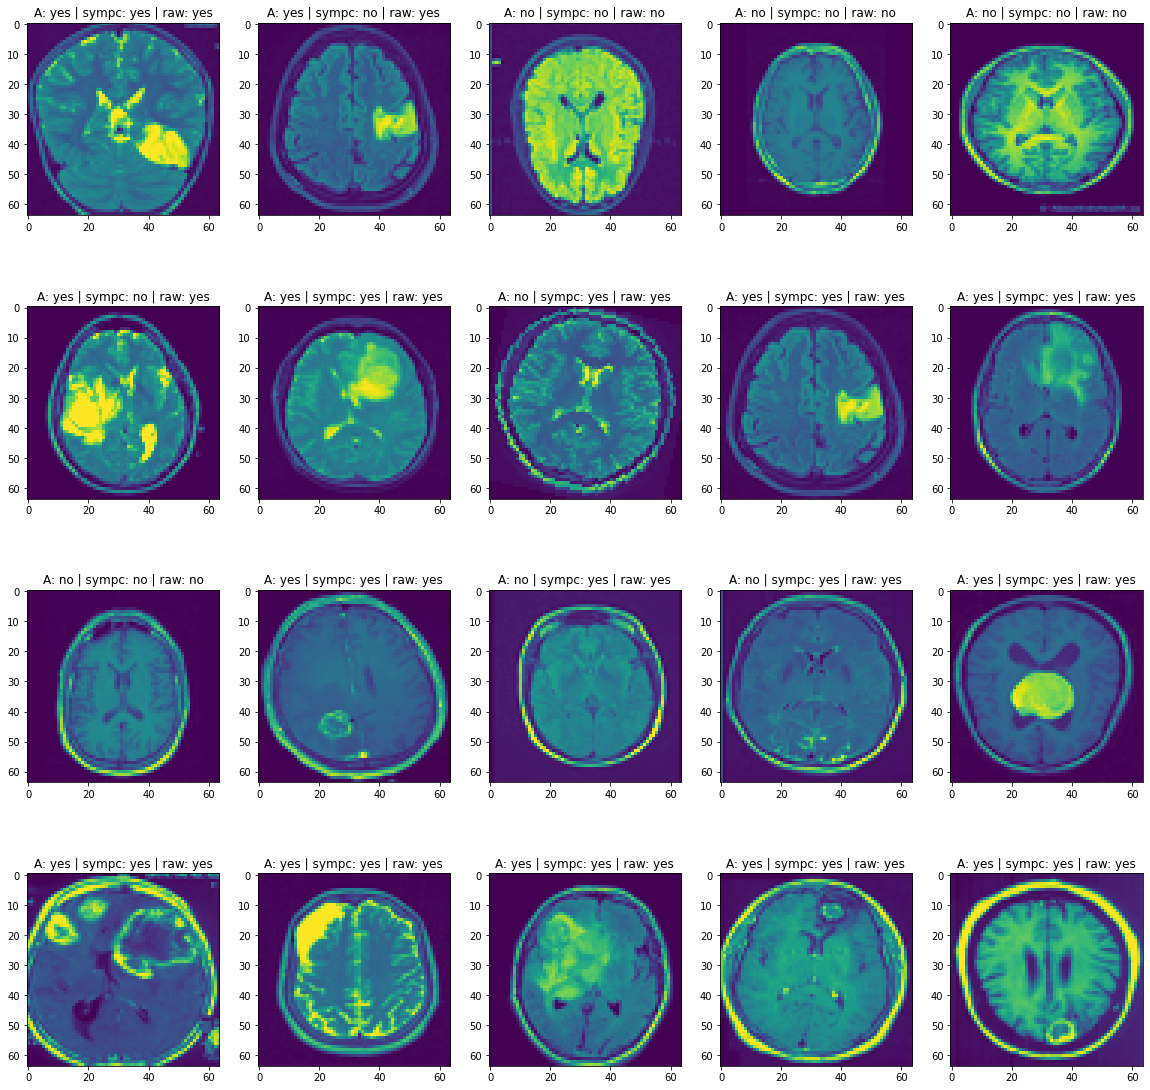

Time for inference: 28741.794840574265
Succes rate (sympc pred/actual labels):  0.79
Succes rate (sympc pred/raw pred):  0.95


In [50]:
fig = plt.figure(figsize=(20,20))
iter_loader = iter(plot_loader)
succes_sympc_overal = 0
succes_sympc_raw = 0
for i in range(20):
    img, label = next(iter_loader)
    pred = results[i]
    raw_pred = raw_predictions[i]
    target = labels[i]
    pred = torch.argmax(pred, dim=1)
    plt.subplot(4,5,i+1)
    plt.imshow(img[0][0])
    plt.title(f"A: {mapping[target.detach().item()]} | " +
              f"sympc: {mapping[pred.detach().item()]} | " +
              f"raw: {mapping[raw_pred.detach().item()]}")
    if pred == label: succes_sympc_overal += 1
    if pred == raw_pred: succes_sympc_raw += 1
    
plt.show()
print(f"Time for inference: {end_time - start_time}")
print(f"Succes rate (sympc pred/actual labels): {succes_sympc_overal/i: .2f}")
print(f"Succes rate (sympc pred/raw pred): {succes_sympc_raw/i: .2f}")